In [ ]:
#!pip install -q scikit-learn seaborn contractions nltk gensim

import os, re, time, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
nltk.download('wordnet', quiet=True)
from nltk.corpus import wordnet
import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

/home/shavak_new/anaconda3/envs/gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-01-22 13:09:37.335432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-22 13:09:37.529301: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-22 13:09:38.153560: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open

Device: cuda


In [ ]:

MODEL_NAME = "bert-base-uncased"   # keep architecture same
MAX_LEN = 256                      # reduce to 128 if OOM
BATCH_SIZE = 8                     # adjust if OOM
EPOCHS = 10
LR = 2e-5
N_SPLITS = 5
SEED = 42
GRAD_ACCUM = 1      # set >1 for gradient accumulation
WEIGHT_DECAY = 0.01
DROPOUT = 0.4
EARLYSTOP_PATIENCE = 3

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [ ]:
raw_df = pd.read_csv("Liar_Dataset.csv")
print('Raw shape:', raw_df.shape)
raw_df.head()

Raw shape: (12787, 14)


,[ID].json,label,statement,subject(s),speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,venue
0,11972.json,TRUE,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,FALSE,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,FALSE,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [ ]:

input_root = '/kaggle/input'
csvs = []
for root, dirs, files in os.walk(input_root):
    for f in files:
        if f.lower().endswith('.csv'):
            csvs.append(os.path.join(root, f))
if len(csvs) == 0:
    raise FileNotFoundError("No CSV found in /kaggle/input. Upload your dataset.")
csv_path = csvs[0]
print("Using CSV:", csv_path)
raw_df = pd.read_csv(csv_path)
print("Raw shape:", raw_df.shape)
display(raw_df.head())

Using CSV: /kaggle/input/liar-twitter-dataset/Liar_Dataset.csv
Raw shape: (12787, 14)


,[ID].json,label,statement,subject(s),speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,venue
0,11972.json,TRUE,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,FALSE,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,FALSE,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [ ]:

label_map = {
    'pants-fire': 0, 'pants on fire': 0, 'pants on fire.': 0,
    'false': 1,
    'barely-true': 2, 'barely true': 2,
    'half-true': 3, 'half true': 3,
    'mostly-true': 4, 'mostly true': 4,
    'true': 5
}


def find_col(df, names):
    for c in df.columns:
        if c.lower() in names:
            return c
    return None


In [ ]:
stmt_col = find_col(raw_df, ['statement','statements','claim','text','statement_text'])
label_col = find_col(raw_df, ['label','labels','label_mapped','truth','veracity','class'])
speaker_col = find_col(raw_df, ['speaker','speaker_name','speakers','speaker_id'])
party_col = find_col(raw_df, ['party','political_party'])
subject_col = find_col(raw_df, ['subject','topic'])
context_col = find_col(raw_df, ['context','source','venue'])

if stmt_col is None or label_col is None:
    raise ValueError("Couldn't auto-detect 'statement' or 'label' columns. Rename CSV columns accordingly.")
print("Detected columns -> statement:", stmt_col, ", label:", label_col)
meta_cols = {}
if speaker_col: meta_cols['speaker'] = speaker_col
if party_col: meta_cols['party'] = party_col
if subject_col: meta_cols['subject'] = subject_col
if context_col: meta_cols['context'] = context_col
print("Detected metadata columns:", meta_cols)

raw_df['label_raw'] = raw_df[label_col].astype(str).str.lower().str.strip()
raw_df['label_mapped'] = raw_df['label_raw'].map(label_map)
if raw_df['label_mapped'].isna().any():
    print("Unmapped labels examples (first 20):", raw_df[raw_df['label_mapped'].isna()][label_col].unique()[:20])

Detected columns -> statement: statement , label: label
Detected metadata columns: {'speaker': 'speaker', 'context': 'venue'}


In [ ]:

keep_cols = [stmt_col, 'label_mapped']
for v in meta_cols.values():
    keep_cols.append(v)
DF = raw_df[keep_cols].dropna(subset=[stmt_col,'label_mapped']).rename(columns={stmt_col:'statement','label_mapped':'label'}).reset_index(drop=True)
DF['label'] = DF['label'].astype(int)
print("Prepared DF shape:", DF.shape)
print(DF['label'].value_counts())

Prepared DF shape: (12787, 4)
label
3    2627
1    2504
4    2454
2    2102
5    2053
0    1047
Name: count, dtype: int64


In [ ]:
def mask_person_names(text):
    toks = text.split()
    i = 0; out=[]
    while i < len(toks):
        if toks[i][0:1].isupper() and toks[i].isalpha():
            j=i+1; seq=[toks[i]]
            while j<len(toks) and toks[j][0:1].isupper() and toks[j].isalpha():
                seq.append(toks[j]); j+=1
            if len(seq)>=1:
                out.append("<person>"); i=j; continue
        out.append(toks[i]); i+=1
    return " ".join(out)

def clean_text(text):
    if not isinstance(text,str): return ""
    text = text.strip().replace('\n',' ').replace('\r',' ')
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'\[.*?\]|\(.*?\)|\<.*?\>', ' ', text)
    text = re.sub(r"[^a-z0-9\s'\.,!?;-]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    toks = text.split()
    for i in range(len(toks)-1):
        if toks[i] in ('not','no','never'):
            toks[i] = toks[i] + "_" + toks[i+1]
            toks[i+1] = ''
    text = " ".join([t for t in toks if t])
    text = mask_person_names(text)
    return text

DF['clean_statement'] = DF['statement'].astype(str).map(clean_text)
DF = DF[DF['clean_statement'].str.len() > 5].reset_index(drop=True)
print("After cleaning:", DF.shape)

After cleaning: (12787, 5)


In [ ]:
# ============ Topic modelling (LDA) - add topic_id metadata ============
n_topics = 10
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
X_counts = vectorizer.fit_transform(DF['clean_statement'].values)
lda = LatentDirichletAllocation(n_components=n_topics, random_state=SEED, n_jobs=-1)
topic_dist = lda.fit_transform(X_counts)
DF['topic_id'] = topic_dist.argmax(axis=1)
print("Topic distribution:", DF['topic_id'].value_counts().to_dict())

Topic distribution: {2: 1649, 7: 1610, 5: 1465, 9: 1360, 1: 1261, 3: 1190, 4: 1124, 0: 1076, 6: 1068, 8: 984}


In [ ]:
# ============ Inject metadata and speaker history into model input ============
def make_model_input(row):
    parts = [row['clean_statement']]
    if 'speaker' in DF.columns and pd.notna(row.get('speaker')):
        parts.append(f"speaker={row.get('speaker')}")
    if 'party' in DF.columns and pd.notna(row.get('party')):
        parts.append(f"party={row.get('party')}")
    if 'subject' in DF.columns and pd.notna(row.get('subject')):
        parts.append(f"subject={row.get('subject')}")
    if 'context' in DF.columns and pd.notna(row.get('context')):
        parts.append(f"context={row.get('context')}")
    parts.append(f"topic={int(row['topic_id'])}")
    return " [SEP] ".join(parts)

DF['model_input'] = DF.apply(make_model_input, axis=1)

# speaker history: true rate per speaker if available
if 'speaker' in DF.columns:
    speaker_true_rate = DF.groupby('speaker')['label'].apply(lambda arr: np.mean(np.array(arr)==5)).to_dict()
    DF['speaker_true_rate'] = DF['speaker'].map(speaker_true_rate).fillna(0.0)
    DF['model_input'] = DF.apply(lambda r: r['model_input'] + f" [SEP] speaker_true_rate={r['speaker_true_rate']:.3f}", axis=1)
else:
    DF['speaker_true_rate'] = 0.0

print("Sample model_input:")
display(DF[['model_input','label']].head())


Sample model_input:


,model_input,label
0,building a wall on the you.s.-mexico border wi...,5
1,wisconsin is on pace to double the number of l...,1
2,says john mccain has done nothing to help the ...,1
3,suzanne bonamici supports a plan that will cut...,3
4,when asked by a reporter whether hes at the ce...,0


In [ ]:
# ============ Tokenizer & Dataset class (with augmentation) ============
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def synonym_replace(text, p=0.05):
    toks = text.split()
    out=[]
    for t in toks:
        if random.random() < p:
            syns = wordnet.synsets(t)
            if syns:
                lemmas = [l.name().replace('_',' ') for s in syns for l in s.lemmas()]
                lemmas = [w for w in lemmas if w.lower()!=t.lower() and w.isalpha()]
                if lemmas:
                    out.append(random.choice(lemmas)); continue
        out.append(t)
    return " ".join(out)

In [ ]:
class LIARDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len, augment=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.augment = augment
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        if self.augment:
            if random.random() < 0.1:
                text = synonym_replace(text, p=0.05)
            if random.random() < 0.05:
                toks = text.split()
                if len(toks)>3:
                    pos = random.randint(0,len(toks)-1)
                    toks[pos] = '[MASK]'; text = ' '.join(toks)
        enc = tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')
        return {'ids': enc['input_ids'].squeeze(0), 'mask': enc['attention_mask'].squeeze(0), 'label': torch.tensor(int(self.labels[idx]), dtype=torch.long)}


In [ ]:

# ============ Model: BERT + BiLSTM + Attention ============
class BertBiLSTMAttn(nn.Module):
    def __init__(self, model_name, lstm_hidden=128, num_classes=6, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.bilstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=lstm_hidden,
            bidirectional=True,
            batch_first=True
        )
        self.attn = nn.Linear(2 * lstm_hidden, 1)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(2 * lstm_hidden, num_classes)

    def forward(self, input_ids, attention_mask, return_attn=False):
        seq = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        lstm_out, _ = self.bilstm(seq)               # (B,T,256)

        scores = self.attn(lstm_out)                # (B,T,1)
        weights = torch.softmax(scores, dim=1)      # attention weights

        context = torch.sum(weights * lstm_out, dim=1)
        context = self.dropout(context)
        logits = self.classifier(context)

        if return_attn:
            return logits, weights.squeeze(-1)
        return logits



In [ ]:
# ============ Training / Eval / EarlyStopping utilities ============
def train_epoch(model, loader, optimizer, scheduler, criterion, grad_accum_steps=1):
    model.train()
    total_loss=0.0; total_correct=0; total_samples=0
    optimizer.zero_grad()
    for step, batch in enumerate(loader, 1):
        ids = batch['ids'].to(device); mask = batch['mask'].to(device); labels = batch['label'].to(device)
        outputs = model(ids, mask)
        loss = criterion(outputs, labels) / grad_accum_steps
        loss.backward()
        if step % grad_accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            if scheduler is not None: scheduler.step()
            optimizer.zero_grad()
        total_loss += loss.item() * grad_accum_steps
        preds = outputs.argmax(1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)
    avg_loss = total_loss / len(loader)
    avg_acc = total_correct / total_samples if total_samples>0 else 0
    return avg_loss, avg_acc

In [ ]:
def eval_model(model, loader, criterion=None):
    model.eval()
    all_preds=[]; all_labels=[]
    total_loss=0.0; total_samples=0
    with torch.no_grad():
        for batch in loader:
            ids = batch['ids'].to(device); mask = batch['mask'].to(device); labels = batch['label'].to(device)
            outputs = model(ids, mask)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy()); all_labels.extend(labels.cpu().numpy())
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item(); total_samples += labels.size(0)
    avg_loss = (total_loss / len(loader)) if (criterion is not None and len(loader)>0) else None
    acc = accuracy_score(all_labels, all_preds) if len(all_labels)>0 else 0
    return avg_loss, acc, np.array(all_labels), np.array(all_preds)

In [ ]:
# ============ Prepare class weights & global criterion ============
classes = np.unique(DF['label'])
class_weights_np = compute_class_weight(class_weight='balanced', classes=classes, y=DF['label'].values)
class_weights = torch.tensor(class_weights_np, dtype=torch.float).to(device)
print("Class weights:", class_weights_np)
criterion_global = nn.CrossEntropyLoss(weight=class_weights)

Class weights: [2.03549825 0.8511049  1.01387567 0.81125492 0.86844607 1.03807436]


In [ ]:
def freeze_bert_layers(model, freeze_until=8):
    """
    Freeze BERT encoder layers from 0 to freeze_until-1.
    Example: freeze_until=8 → layers 0..7 frozen, 8..11 trainable.
    """
    for name, param in model.bert.named_parameters():
        if "encoder.layer" in name:
            layer_num = int(name.split("encoder.layer.")[1].split(".")[0])
            if layer_num < freeze_until:
                param.requires_grad = False
            else:
                param.requires_grad = True
        else:
            # embeddings etc.
            param.requires_grad = False


def unfreeze_all_bert(model):
    """Unfreeze all BERT layers for full fine-tuning."""
    for param in model.bert.parameters():
        param.requires_grad = True


In [ ]:
all_y_true =[]
all_y_pred=[]
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

In [ ]:
%%bash
ls

bash: /home/shavak_new/anaconda3/envs/gpu/lib/libtinfo.so.6: no version information available (required by bash)


baseline-fakenews copy.ipynb
baseline-fakenews.ipynb
baseline_fakenews.py
gpu_setup.py
gpu_train.py
install_gpu.sh
Liar_Dataset.csv
models
modified-fake-news (1).ipynb
modified-fake-news (2).ipynb
modified_fake_news_detection.py
plot_results.py
requirements.txt




===== FOLD 1/5 =====


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train Loss 1.6450 | Train Acc 0.2497
Val   Loss 1.6224 | Val   Acc 0.2584 

Overall metrics:
Accuracy: 0.2584  Precision: 0.2473  Recall: 0.2584  F1: 0.2211

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.1599    0.7714    0.2649       210
       false     0.0000    0.0000    0.0000       501
 barely-true     0.1895    0.1548    0.1704       420
   half-true     0.2867    0.0819    0.1274       525
 mostly-true     0.2875    0.4216    0.3419       491
        true     0.5542    0.4477    0.4953       411

    accuracy                         0.2584      2558
   macro avg     0.2463    0.3129    0.2333      2558
weighted avg     0.2473    0.2584    0.2211      2558



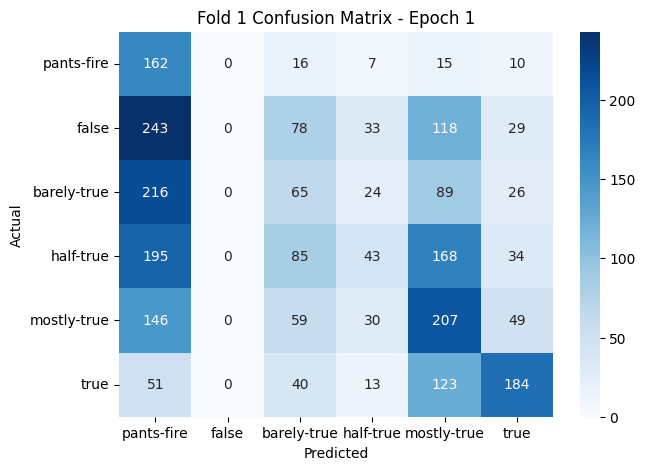

Saved best model for fold 1 (val_acc=0.2584)
Train Loss 1.3729 | Train Acc 0.3910
Val   Loss 1.6452 | Val   Acc 0.2959 

Overall metrics:
Accuracy: 0.2959  Precision: 0.3053  Recall: 0.2959  F1: 0.2838

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.2511    0.5238    0.3395       210
       false     0.2494    0.2076    0.2266       501
 barely-true     0.2324    0.3929    0.2920       420
   half-true     0.2781    0.0990    0.1461       525
 mostly-true     0.3022    0.2566    0.2775       491
        true     0.5141    0.4866    0.5000       411

    accuracy                         0.2959      2558
   macro avg     0.3046    0.3278    0.2970      2558
weighted avg     0.3053    0.2959    0.2838      2558



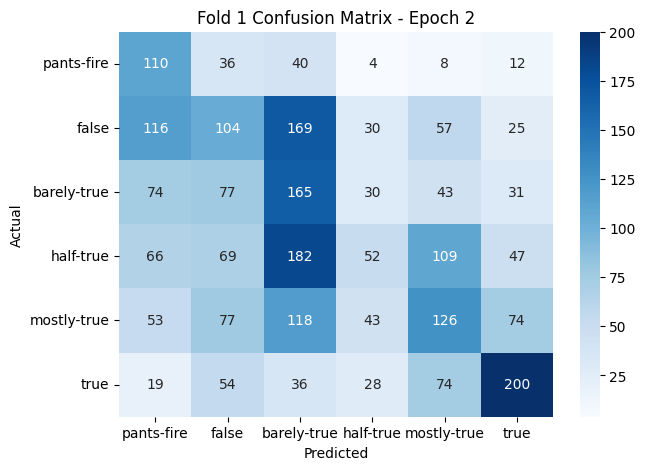

Saved best model for fold 1 (val_acc=0.2959)
Train Loss 1.0903 | Train Acc 0.5241
Val   Loss 1.7378 | Val   Acc 0.3061 

Overall metrics:
Accuracy: 0.3061  Precision: 0.2975  Recall: 0.3061  F1: 0.2826

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4028    0.2762    0.3277       210
       false     0.3077    0.2874    0.2972       501
 barely-true     0.2295    0.3000    0.2601       420
   half-true     0.2407    0.0495    0.0821       525
 mostly-true     0.2680    0.3788    0.3139       491
        true     0.4084    0.5912    0.4831       411

    accuracy                         0.3061      2558
   macro avg     0.3095    0.3139    0.2940      2558
weighted avg     0.2975    0.3061    0.2826      2558



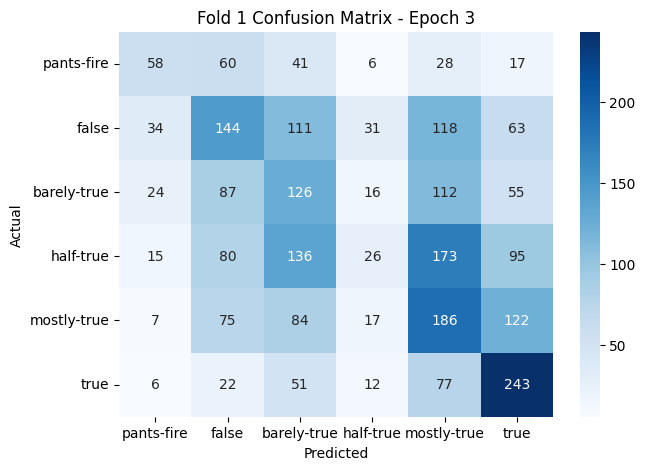

Saved best model for fold 1 (val_acc=0.3061)
Train Loss 0.8701 | Train Acc 0.6272
Val   Loss 1.9465 | Val   Acc 0.2948 

Overall metrics:
Accuracy: 0.2948  Precision: 0.2905  Recall: 0.2948  F1: 0.2827

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4437    0.3000    0.3580       210
       false     0.2741    0.3912    0.3224       501
 barely-true     0.2059    0.2333    0.2187       420
   half-true     0.2423    0.1048    0.1463       525
 mostly-true     0.2505    0.2444    0.2474       491
        true     0.4277    0.5401    0.4774       411

    accuracy                         0.2948      2558
   macro avg     0.3074    0.3023    0.2950      2558
weighted avg     0.2905    0.2948    0.2827      2558



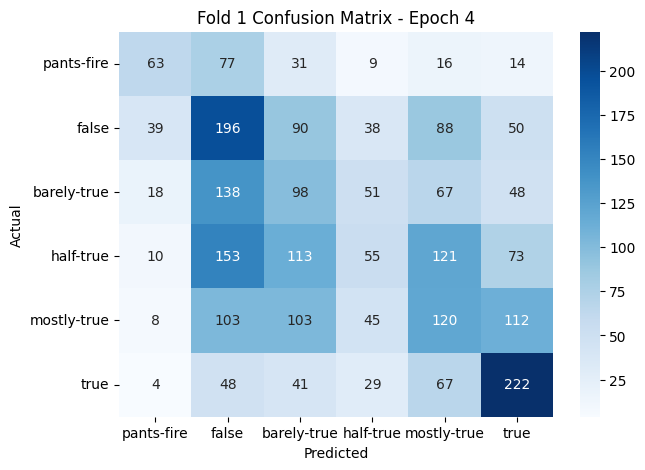

Train Loss 0.6770 | Train Acc 0.7201
Val   Loss 2.2363 | Val   Acc 0.2928 

Overall metrics:
Accuracy: 0.2928  Precision: 0.3151  Recall: 0.2928  F1: 0.2966

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4694    0.2190    0.2987       210
       false     0.3109    0.2495    0.2769       501
 barely-true     0.2155    0.2119    0.2137       420
   half-true     0.2323    0.3067    0.2644       525
 mostly-true     0.2516    0.3218    0.2824       491
        true     0.5247    0.4136    0.4626       411

    accuracy                         0.2928      2558
   macro avg     0.3341    0.2871    0.2998      2558
weighted avg     0.3151    0.2928    0.2966      2558



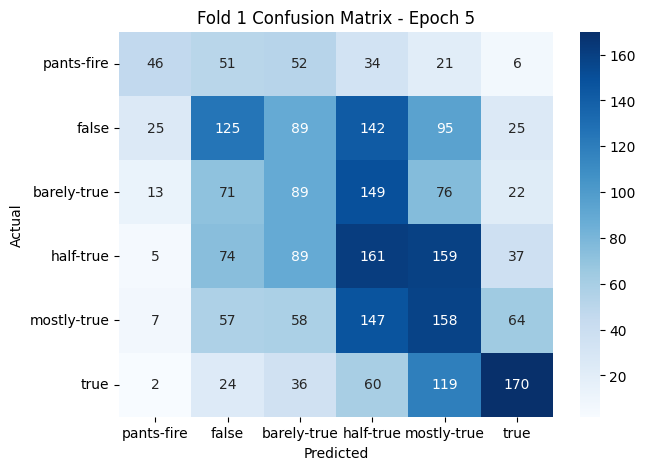

Train Loss 0.5389 | Train Acc 0.7780
Val   Loss 2.3993 | Val   Acc 0.3069 

Overall metrics:
Accuracy: 0.3069  Precision: 0.3218  Recall: 0.3069  F1: 0.3052

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4706    0.2286    0.3077       210
       false     0.2901    0.3613    0.3218       501
 barely-true     0.2205    0.3071    0.2567       420
   half-true     0.2680    0.2971    0.2818       525
 mostly-true     0.2993    0.1670    0.2144       491
        true     0.4834    0.4599    0.4713       411

    accuracy                         0.3069      2558
   macro avg     0.3386    0.3035    0.3090      2558
weighted avg     0.3218    0.3069    0.3052      2558



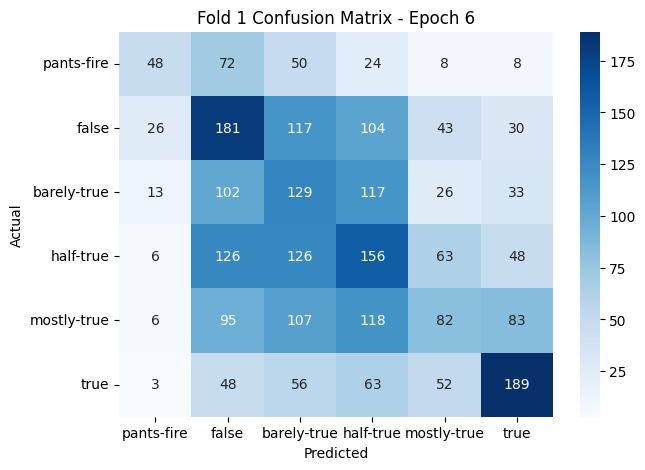

Saved best model for fold 1 (val_acc=0.3069)
Train Loss 0.4220 | Train Acc 0.8372
Val   Loss 2.6766 | Val   Acc 0.3124 

Overall metrics:
Accuracy: 0.3124  Precision: 0.3258  Recall: 0.3124  F1: 0.3131

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4667    0.2667    0.3394       210
       false     0.2899    0.3912    0.3331       501
 barely-true     0.2312    0.1905    0.2089       420
   half-true     0.2595    0.3257    0.2889       525
 mostly-true     0.2840    0.2464    0.2639       491
        true     0.5287    0.4258    0.4717       411

    accuracy                         0.3124      2558
   macro avg     0.3433    0.3077    0.3176      2558
weighted avg     0.3258    0.3124    0.3131      2558



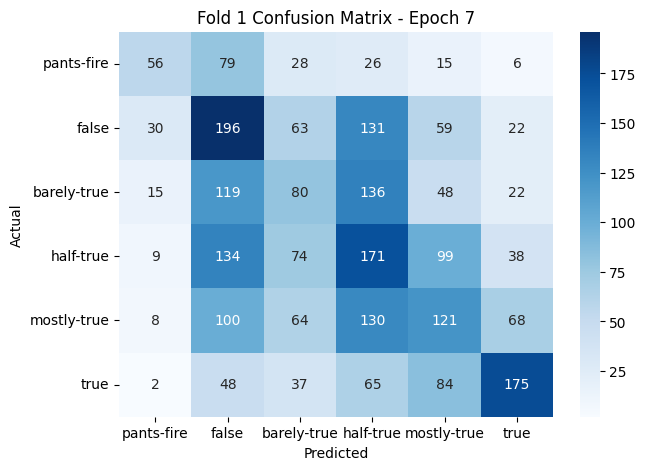

Saved best model for fold 1 (val_acc=0.3124)
Train Loss 0.3411 | Train Acc 0.8731
Val   Loss 3.0972 | Val   Acc 0.3002 

Overall metrics:
Accuracy: 0.3002  Precision: 0.3247  Recall: 0.3002  F1: 0.3039

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4946    0.2190    0.3036       210
       false     0.3008    0.2275    0.2591       501
 barely-true     0.2230    0.3000    0.2558       420
   half-true     0.2671    0.3124    0.2880       525
 mostly-true     0.2622    0.3177    0.2873       491
        true     0.5192    0.3942    0.4481       411

    accuracy                         0.3002      2558
   macro avg     0.3445    0.2951    0.3070      2558
weighted avg     0.3247    0.3002    0.3039      2558



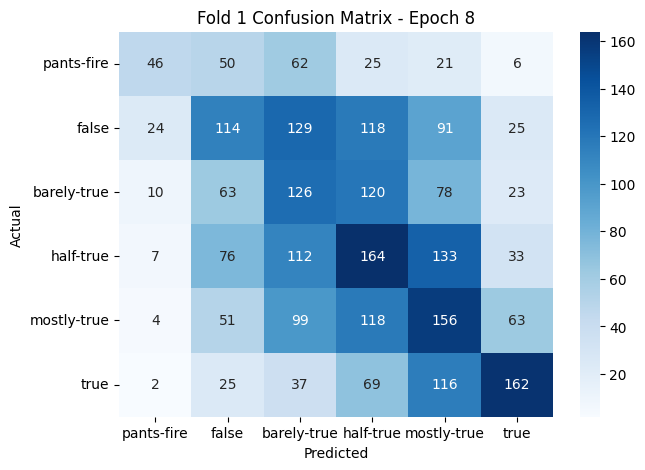

Train Loss 0.2845 | Train Acc 0.8994
Val   Loss 3.2534 | Val   Acc 0.3045 

Overall metrics:
Accuracy: 0.3045  Precision: 0.3213  Recall: 0.3045  F1: 0.3067

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4674    0.2048    0.2848       210
       false     0.2903    0.2695    0.2795       501
 barely-true     0.2320    0.3214    0.2695       420
   half-true     0.2628    0.3029    0.2814       525
 mostly-true     0.2819    0.2607    0.2709       491
        true     0.4972    0.4355    0.4643       411

    accuracy                         0.3045      2558
   macro avg     0.3386    0.2991    0.3084      2558
weighted avg     0.3213    0.3045    0.3067      2558



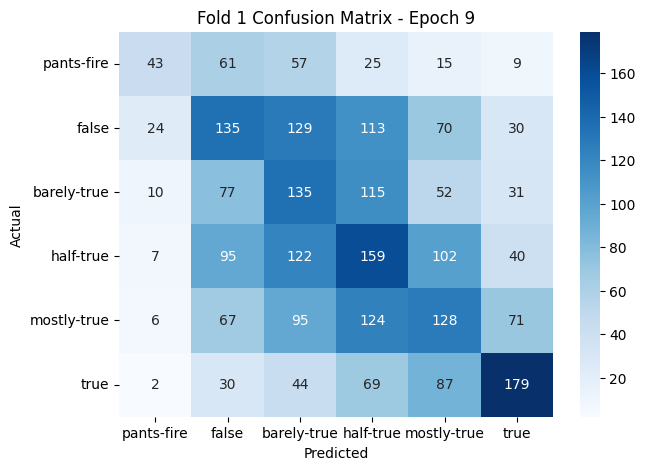

Train Loss 0.2569 | Train Acc 0.9130
Val   Loss 3.3335 | Val   Acc 0.3077 

Overall metrics:
Accuracy: 0.3077  Precision: 0.3246  Recall: 0.3077  F1: 0.3103

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4688    0.2143    0.2941       210
       false     0.3036    0.3393    0.3205       501
 barely-true     0.2367    0.2429    0.2397       420
   half-true     0.2569    0.3200    0.2850       525
 mostly-true     0.2735    0.2729    0.2732       491
        true     0.5138    0.4088    0.4553       411

    accuracy                         0.3077      2558
   macro avg     0.3422    0.2997    0.3113      2558
weighted avg     0.3246    0.3077    0.3103      2558



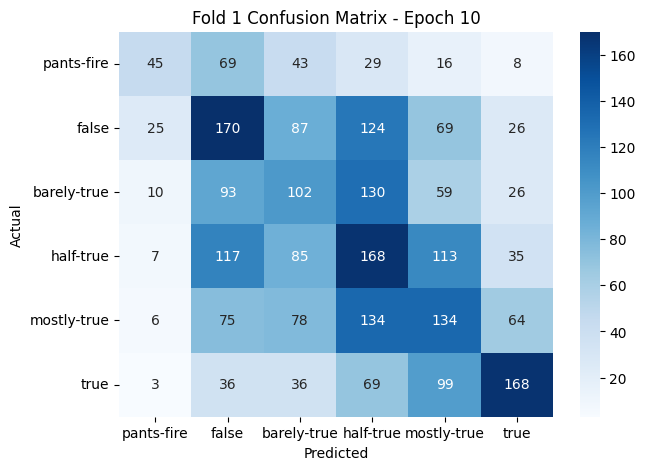

Best val acc fold 1: 0.3124


===== FOLD 2/5 =====


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train Loss 1.6249 | Train Acc 0.2573
Val   Loss 1.6235 | Val   Acc 0.2654 

Overall metrics:
Accuracy: 0.2654  Precision: 0.2540  Recall: 0.2654  F1: 0.2180

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.1867    0.5789    0.2824       209
       false     0.2374    0.1597    0.1909       501
 barely-true     0.2233    0.0546    0.0878       421
   half-true     0.2455    0.0514    0.0850       525
 mostly-true     0.2544    0.2627    0.2585       491
        true     0.3505    0.7275    0.4731       411

    accuracy                         0.2654      2558
   macro avg     0.2496    0.3058    0.2296      2558
weighted avg     0.2540    0.2654    0.2180      2558



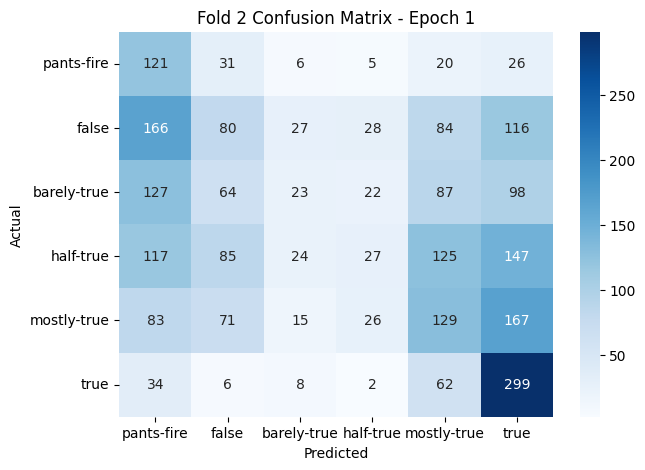

Saved best model for fold 2 (val_acc=0.2654)
Train Loss 1.3188 | Train Acc 0.4124
Val   Loss 1.6436 | Val   Acc 0.3155 

Overall metrics:
Accuracy: 0.3155  Precision: 0.3141  Recall: 0.3155  F1: 0.3070

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3143    0.2105    0.2521       209
       false     0.3307    0.3293    0.3300       501
 barely-true     0.2171    0.3254    0.2605       421
   half-true     0.2737    0.1429    0.1877       525
 mostly-true     0.3050    0.3136    0.3092       491
        true     0.4558    0.5645    0.5043       411

    accuracy                         0.3155      2558
   macro avg     0.3161    0.3144    0.3073      2558
weighted avg     0.3141    0.3155    0.3070      2558



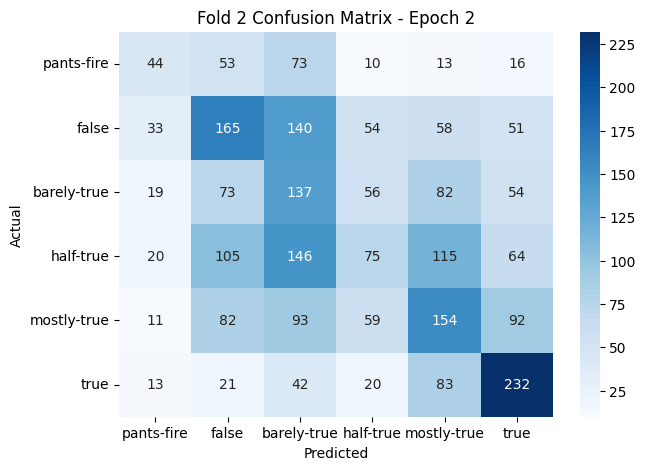

Saved best model for fold 2 (val_acc=0.3155)
Train Loss 1.0841 | Train Acc 0.5175
Val   Loss 1.7828 | Val   Acc 0.3006 

Overall metrics:
Accuracy: 0.3006  Precision: 0.3231  Recall: 0.3006  F1: 0.2978

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3529    0.2584    0.2983       209
       false     0.3497    0.1996    0.2541       501
 barely-true     0.2051    0.4418    0.2801       421
   half-true     0.2903    0.1886    0.2286       525
 mostly-true     0.2948    0.2749    0.2845       491
        true     0.4722    0.4745    0.4733       411

    accuracy                         0.3006      2558
   macro avg     0.3275    0.3063    0.3032      2558
weighted avg     0.3231    0.3006    0.2978      2558



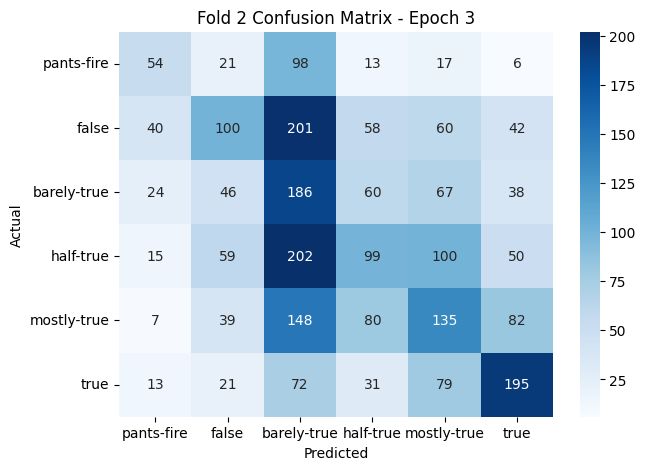

Train Loss 0.8621 | Train Acc 0.6290
Val   Loss 1.9604 | Val   Acc 0.3249 

Overall metrics:
Accuracy: 0.3249  Precision: 0.3271  Recall: 0.3249  F1: 0.3256

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3056    0.2632    0.2828       209
       false     0.3235    0.3273    0.3254       501
 barely-true     0.2401    0.2732    0.2556       421
   half-true     0.2803    0.2819    0.2811       525
 mostly-true     0.3333    0.3116    0.3221       491
        true     0.4840    0.4769    0.4804       411

    accuracy                         0.3249      2558
   macro avg     0.3278    0.3223    0.3246      2558
weighted avg     0.3271    0.3249    0.3256      2558



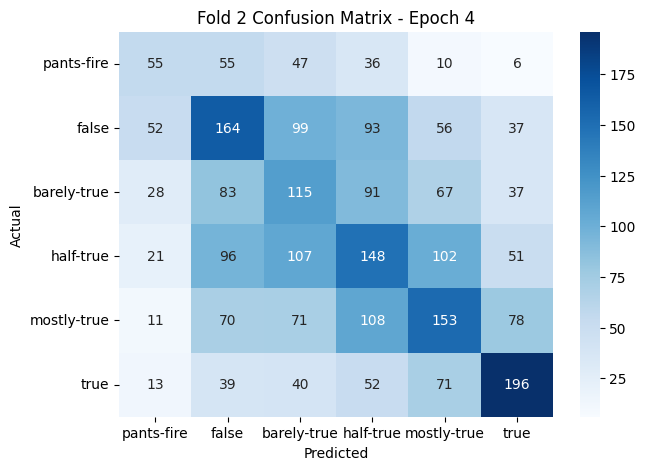

Saved best model for fold 2 (val_acc=0.3249)
Train Loss 0.6824 | Train Acc 0.7164
Val   Loss 2.1573 | Val   Acc 0.3092 

Overall metrics:
Accuracy: 0.3092  Precision: 0.3249  Recall: 0.3092  F1: 0.3086

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3291    0.2488    0.2834       209
       false     0.3604    0.2216    0.2744       501
 barely-true     0.2113    0.3824    0.2722       421
   half-true     0.2806    0.2229    0.2484       525
 mostly-true     0.2964    0.2994    0.2979       491
        true     0.4868    0.4939    0.4903       411

    accuracy                         0.3092      2558
   macro avg     0.3274    0.3115    0.3111      2558
weighted avg     0.3249    0.3092    0.3086      2558



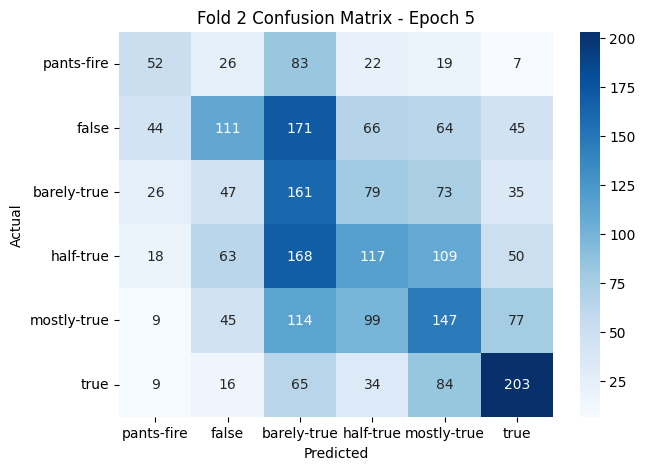

Train Loss 0.5209 | Train Acc 0.7943
Val   Loss 2.4192 | Val   Acc 0.3127 

Overall metrics:
Accuracy: 0.3127  Precision: 0.3131  Recall: 0.3127  F1: 0.3093

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3750    0.2010    0.2617       209
       false     0.3202    0.3573    0.3377       501
 barely-true     0.2283    0.1995    0.2129       421
   half-true     0.2468    0.2229    0.2342       525
 mostly-true     0.2846    0.3646    0.3196       491
        true     0.4784    0.4842    0.4813       411

    accuracy                         0.3127      2558
   macro avg     0.3222    0.3049    0.3079      2558
weighted avg     0.3131    0.3127    0.3093      2558



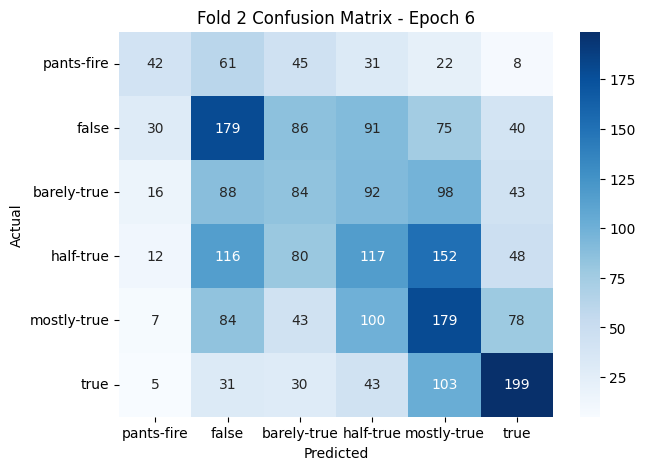

Train Loss 0.4132 | Train Acc 0.8408
Val   Loss 2.7488 | Val   Acc 0.3186 

Overall metrics:
Accuracy: 0.3186  Precision: 0.3218  Recall: 0.3186  F1: 0.3079

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4286    0.1148    0.1811       209
       false     0.3353    0.3333    0.3343       501
 barely-true     0.2492    0.1853    0.2125       421
   half-true     0.2604    0.2267    0.2424       525
 mostly-true     0.2887    0.4562    0.3536       491
        true     0.4432    0.4939    0.4672       411

    accuracy                         0.3186      2558
   macro avg     0.3342    0.3017    0.2985      2558
weighted avg     0.3218    0.3186    0.3079      2558



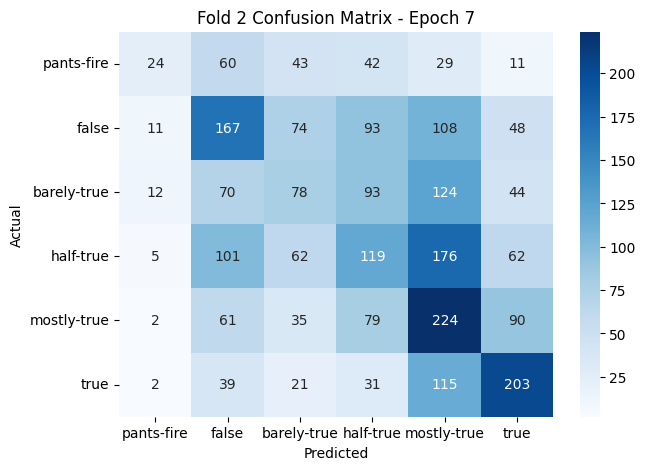

Train Loss 0.3268 | Train Acc 0.8802
Val   Loss 3.0236 | Val   Acc 0.3256 

Overall metrics:
Accuracy: 0.3256  Precision: 0.3261  Recall: 0.3256  F1: 0.3140

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4638    0.1531    0.2302       209
       false     0.3252    0.3713    0.3467       501
 barely-true     0.2442    0.1496    0.1856       421
   half-true     0.2727    0.2343    0.2520       525
 mostly-true     0.2910    0.4297    0.3470       491
        true     0.4513    0.5304    0.4877       411

    accuracy                         0.3256      2558
   macro avg     0.3414    0.3114    0.3082      2558
weighted avg     0.3261    0.3256    0.3140      2558



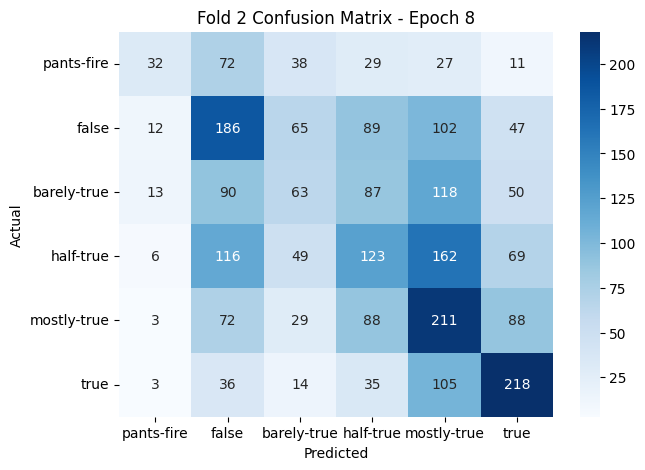

Saved best model for fold 2 (val_acc=0.3256)
Train Loss 0.2629 | Train Acc 0.9075
Val   Loss 3.2127 | Val   Acc 0.3159 

Overall metrics:
Accuracy: 0.3159  Precision: 0.3286  Recall: 0.3159  F1: 0.3174

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3804    0.1675    0.2326       209
       false     0.3290    0.3533    0.3407       501
 barely-true     0.2133    0.2518    0.2309       421
   half-true     0.2707    0.2800    0.2753       525
 mostly-true     0.3070    0.3483    0.3263       491
        true     0.5196    0.4185    0.4636       411

    accuracy                         0.3159      2558
   macro avg     0.3367    0.3032    0.3116      2558
weighted avg     0.3286    0.3159    0.3174      2558



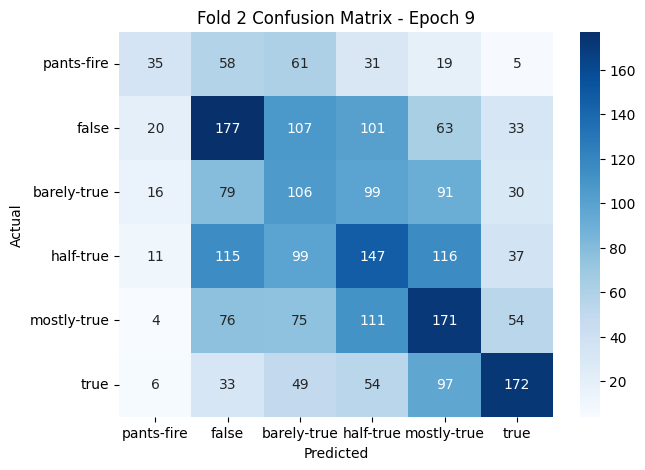

Train Loss 0.2322 | Train Acc 0.9221
Val   Loss 3.3139 | Val   Acc 0.3210 

Overall metrics:
Accuracy: 0.3210  Precision: 0.3324  Recall: 0.3210  F1: 0.3199

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4250    0.1627    0.2353       209
       false     0.3281    0.3772    0.3510       501
 barely-true     0.2369    0.2043    0.2194       421
   half-true     0.2573    0.3029    0.2782       525
 mostly-true     0.3046    0.3605    0.3302       491
        true     0.5176    0.4282    0.4687       411

    accuracy                         0.3210      2558
   macro avg     0.3449    0.3060    0.3138      2558
weighted avg     0.3324    0.3210    0.3199      2558



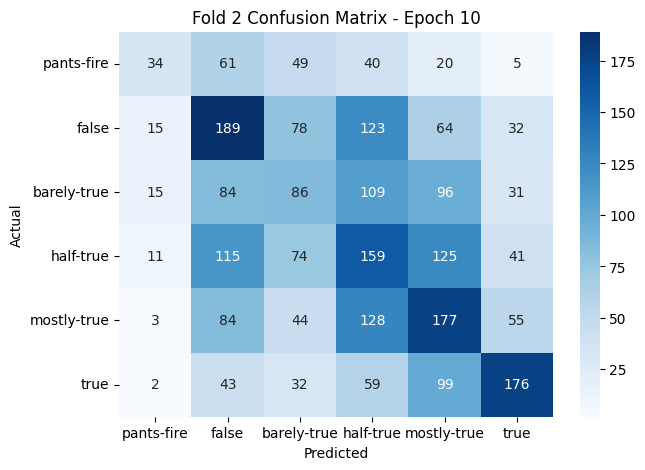

Best val acc fold 2: 0.3256


===== FOLD 3/5 =====


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train Loss 1.6271 | Train Acc 0.2500
Val   Loss 1.6106 | Val   Acc 0.2882 

Overall metrics:
Accuracy: 0.2882  Precision: 0.2315  Recall: 0.2882  F1: 0.2279

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.1931    0.5359    0.2839       209
       false     0.0000    0.0000    0.0000       500
 barely-true     0.2251    0.5154    0.3134       421
   half-true     0.1800    0.0171    0.0312       526
 mostly-true     0.3494    0.2959    0.3204       490
        true     0.4644    0.6180    0.5303       411

    accuracy                         0.2882      2557
   macro avg     0.2353    0.3304    0.2465      2557
weighted avg     0.2315    0.2882    0.2279      2557



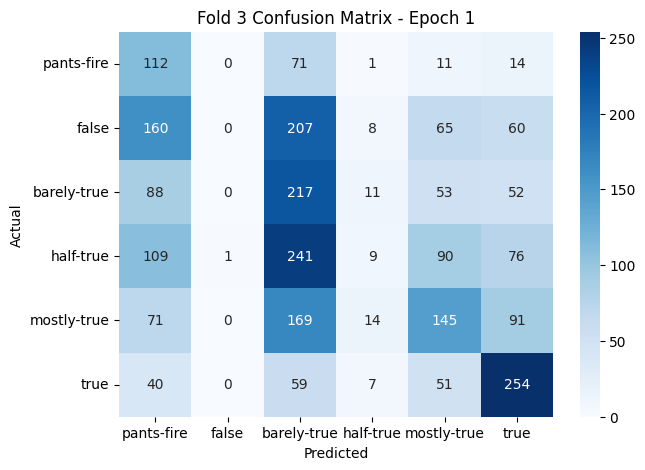

Saved best model for fold 3 (val_acc=0.2882)
Train Loss 1.3012 | Train Acc 0.4208
Val   Loss 1.6381 | Val   Acc 0.3250 

Overall metrics:
Accuracy: 0.3250  Precision: 0.3265  Recall: 0.3250  F1: 0.3040

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3487    0.3254    0.3366       209
       false     0.3370    0.1860    0.2397       500
 barely-true     0.2399    0.4109    0.3030       421
   half-true     0.3257    0.1616    0.2160       526
 mostly-true     0.3190    0.2429    0.2758       490
        true     0.4008    0.7129    0.5131       411

    accuracy                         0.3250      2557
   macro avg     0.3285    0.3399    0.3140      2557
weighted avg     0.3265    0.3250    0.3040      2557



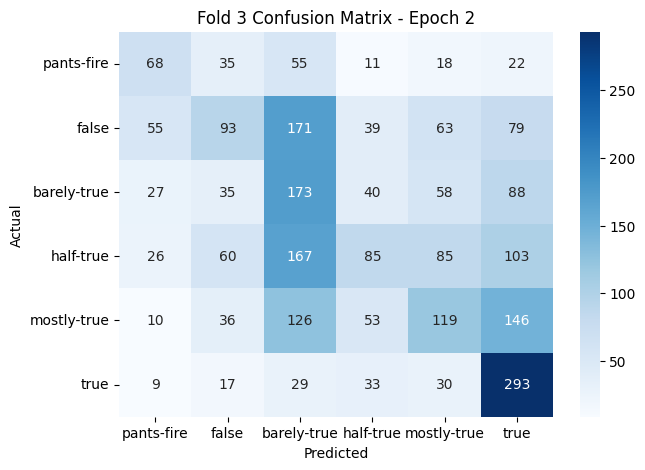

Saved best model for fold 3 (val_acc=0.3250)
Train Loss 1.0722 | Train Acc 0.5221
Val   Loss 1.7281 | Val   Acc 0.3168 

Overall metrics:
Accuracy: 0.3168  Precision: 0.3257  Recall: 0.3168  F1: 0.3074

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3937    0.3014    0.3415       209
       false     0.3109    0.2120    0.2521       500
 barely-true     0.2406    0.5178    0.3286       421
   half-true     0.2822    0.1958    0.2312       526
 mostly-true     0.2799    0.1959    0.2305       490
        true     0.5068    0.5450    0.5252       411

    accuracy                         0.3168      2557
   macro avg     0.3357    0.3280    0.3182      2557
weighted avg     0.3257    0.3168    0.3074      2557



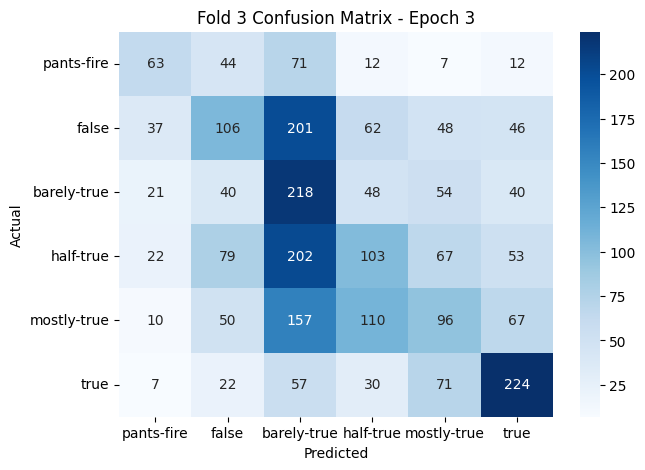

Train Loss 0.8433 | Train Acc 0.6407
Val   Loss 1.9017 | Val   Acc 0.3027 

Overall metrics:
Accuracy: 0.3027  Precision: 0.3089  Recall: 0.3027  F1: 0.3025

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3856    0.2823    0.3260       209
       false     0.2655    0.2660    0.2657       500
 barely-true     0.2178    0.3135    0.2571       421
   half-true     0.2351    0.2243    0.2296       526
 mostly-true     0.3140    0.2327    0.2673       490
        true     0.5046    0.5304    0.5172       411

    accuracy                         0.3027      2557
   macro avg     0.3204    0.3082    0.3105      2557
weighted avg     0.3089    0.3027    0.3025      2557



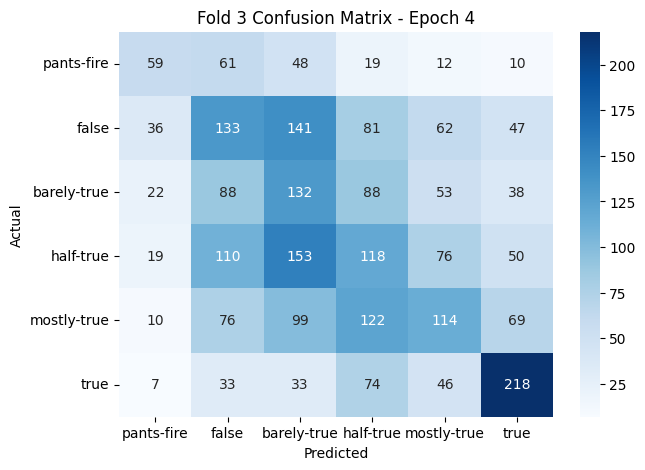

Train Loss 0.6571 | Train Acc 0.7285
Val   Loss 2.1088 | Val   Acc 0.3195 

Overall metrics:
Accuracy: 0.3195  Precision: 0.3273  Recall: 0.3195  F1: 0.3173

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4902    0.2392    0.3215       209
       false     0.2941    0.2100    0.2450       500
 barely-true     0.2522    0.2779    0.2644       421
   half-true     0.2740    0.3479    0.3065       526
 mostly-true     0.2715    0.2898    0.2804       490
        true     0.4966    0.5353    0.5152       411

    accuracy                         0.3195      2557
   macro avg     0.3464    0.3167    0.3222      2557
weighted avg     0.3273    0.3195    0.3173      2557



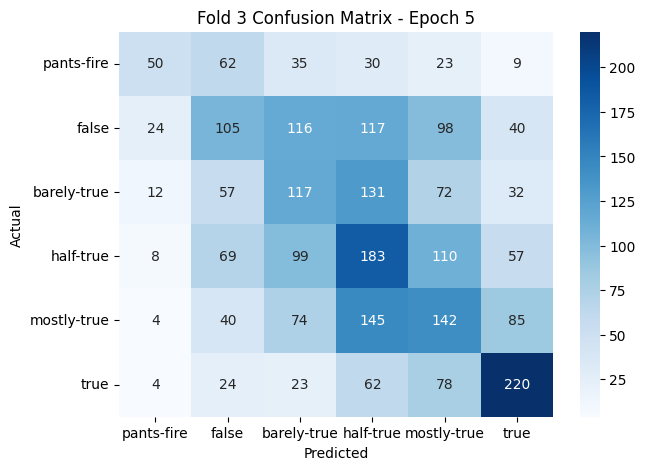

Train Loss 0.5147 | Train Acc 0.7945
Val   Loss 2.3958 | Val   Acc 0.3340 

Overall metrics:
Accuracy: 0.3340  Precision: 0.3360  Recall: 0.3340  F1: 0.3267

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.5104    0.2344    0.3213       209
       false     0.2939    0.3780    0.3307       500
 barely-true     0.2831    0.1829    0.2222       421
   half-true     0.2922    0.2700    0.2806       526
 mostly-true     0.2839    0.3163    0.2992       490
        true     0.4708    0.5888    0.5232       411

    accuracy                         0.3340      2557
   macro avg     0.3557    0.3284    0.3296      2557
weighted avg     0.3360    0.3340    0.3267      2557



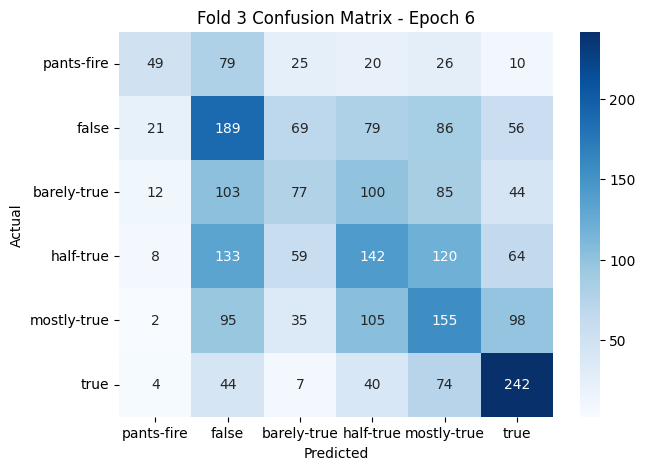

Saved best model for fold 3 (val_acc=0.3340)
Train Loss 0.4016 | Train Acc 0.8418
Val   Loss 2.6465 | Val   Acc 0.3168 

Overall metrics:
Accuracy: 0.3168  Precision: 0.3265  Recall: 0.3168  F1: 0.3159

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.5165    0.2249    0.3133       209
       false     0.2797    0.2780    0.2788       500
 barely-true     0.2567    0.2945    0.2743       421
   half-true     0.2561    0.3004    0.2765       526
 mostly-true     0.2952    0.2531    0.2725       490
        true     0.4855    0.5304    0.5070       411

    accuracy                         0.3168      2557
   macro avg     0.3483    0.3135    0.3204      2557
weighted avg     0.3265    0.3168    0.3159      2557



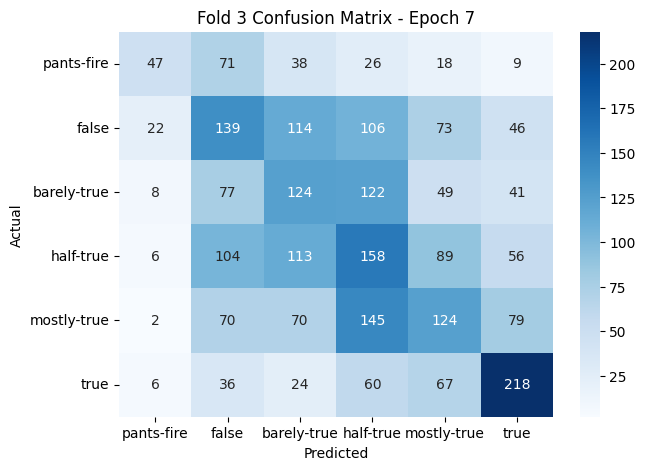

Train Loss 0.3277 | Train Acc 0.8824
Val   Loss 2.9823 | Val   Acc 0.3129 

Overall metrics:
Accuracy: 0.3129  Precision: 0.3198  Recall: 0.3129  F1: 0.3088

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.5155    0.2392    0.3268       209
       false     0.2706    0.2960    0.2827       500
 barely-true     0.2527    0.1663    0.2006       421
   half-true     0.2594    0.3536    0.2993       526
 mostly-true     0.2888    0.2694    0.2788       490
        true     0.4632    0.5207    0.4903       411

    accuracy                         0.3129      2557
   macro avg     0.3417    0.3075    0.3131      2557
weighted avg     0.3198    0.3129    0.3088      2557



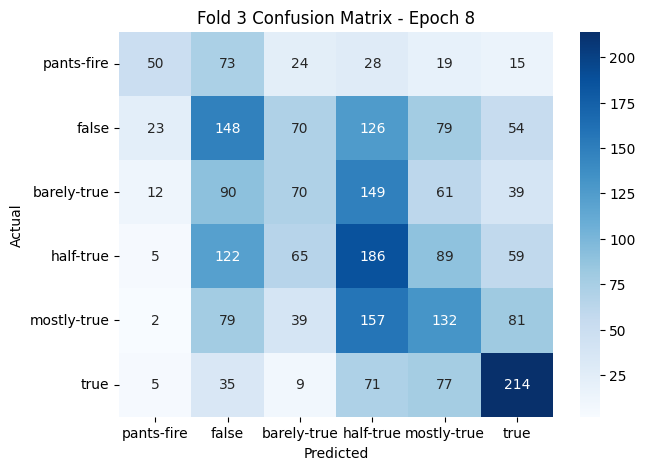

Train Loss 0.2721 | Train Acc 0.9061
Val   Loss 3.2082 | Val   Acc 0.3101 

Overall metrics:
Accuracy: 0.3101  Precision: 0.3221  Recall: 0.3101  F1: 0.3121

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4815    0.2488    0.3281       209
       false     0.2720    0.2780    0.2750       500
 barely-true     0.2410    0.2375    0.2392       421
   half-true     0.2609    0.3289    0.2910       526
 mostly-true     0.2934    0.2898    0.2916       490
        true     0.4973    0.4550    0.4752       411

    accuracy                         0.3101      2557
   macro avg     0.3410    0.3063    0.3167      2557
weighted avg     0.3221    0.3101    0.3121      2557



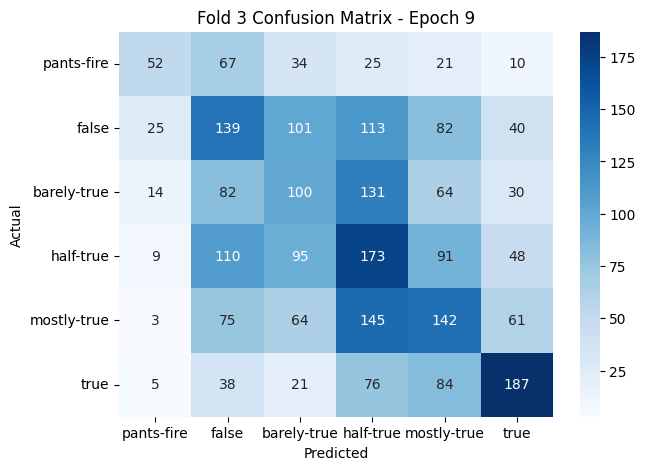

Train Loss 0.2249 | Train Acc 0.9226
Val   Loss 3.3224 | Val   Acc 0.3113 

Overall metrics:
Accuracy: 0.3113  Precision: 0.3248  Recall: 0.3113  F1: 0.3129

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.5053    0.2297    0.3158       209
       false     0.2779    0.3040    0.2904       500
 barely-true     0.2368    0.2233    0.2298       421
   half-true     0.2683    0.3270    0.2948       526
 mostly-true     0.2817    0.2898    0.2857       490
        true     0.5040    0.4574    0.4796       411

    accuracy                         0.3113      2557
   macro avg     0.3457    0.3052    0.3160      2557
weighted avg     0.3248    0.3113    0.3129      2557



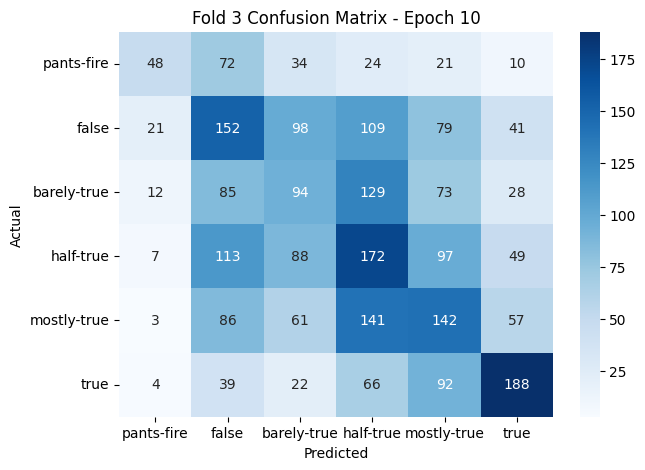

Best val acc fold 3: 0.3340


===== FOLD 4/5 =====


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train Loss 1.6417 | Train Acc 0.2481
Val   Loss 1.8028 | Val   Acc 0.2171 

Overall metrics:
Accuracy: 0.2171  Precision: 0.1722  Recall: 0.2171  F1: 0.1407

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.1259    0.8708    0.2199       209
       false     0.0000    0.0000    0.0000       501
 barely-true     0.0882    0.0071    0.0132       420
   half-true     0.1667    0.0019    0.0038       526
 mostly-true     0.2747    0.1813    0.2184       491
        true     0.3763    0.6829    0.4853       410

    accuracy                         0.2171      2557
   macro avg     0.1720    0.2907    0.1568      2557
weighted avg     0.1722    0.2171    0.1407      2557



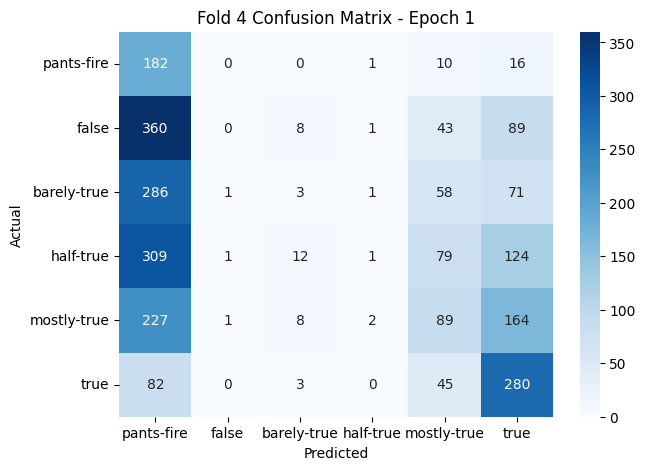

Saved best model for fold 4 (val_acc=0.2171)
Train Loss 1.3336 | Train Acc 0.4091
Val   Loss 1.6554 | Val   Acc 0.3023 

Overall metrics:
Accuracy: 0.3023  Precision: 0.3119  Recall: 0.3023  F1: 0.2635

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3146    0.4833    0.3811       209
       false     0.3559    0.1577    0.2185       501
 barely-true     0.2235    0.2310    0.2272       420
   half-true     0.2750    0.0209    0.0389       526
 mostly-true     0.2597    0.5866    0.3600       491
        true     0.4571    0.4805    0.4685       410

    accuracy                         0.3023      2557
   macro avg     0.3143    0.3266    0.2824      2557
weighted avg     0.3119    0.3023    0.2635      2557



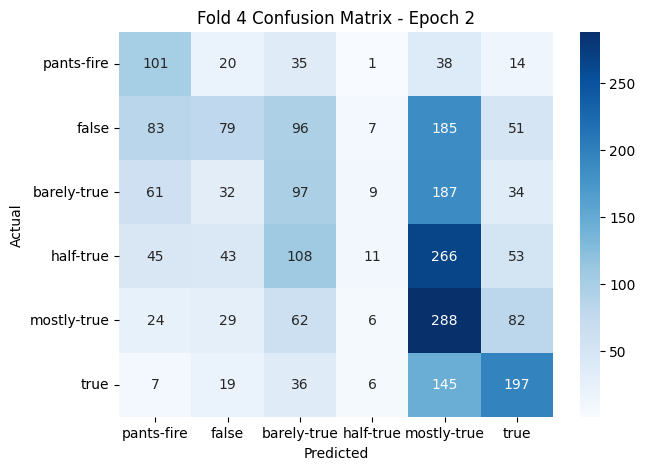

Saved best model for fold 4 (val_acc=0.3023)
Train Loss 1.0792 | Train Acc 0.5294
Val   Loss 1.7675 | Val   Acc 0.3050 

Overall metrics:
Accuracy: 0.3050  Precision: 0.3158  Recall: 0.3050  F1: 0.2875

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4420    0.2919    0.3516       209
       false     0.3441    0.2136    0.2635       501
 barely-true     0.2265    0.2643    0.2440       420
   half-true     0.2909    0.0913    0.1389       526
 mostly-true     0.2516    0.4745    0.3289       491
        true     0.4175    0.5366    0.4696       410

    accuracy                         0.3050      2557
   macro avg     0.3288    0.3120    0.2994      2557
weighted avg     0.3158    0.3050    0.2875      2557



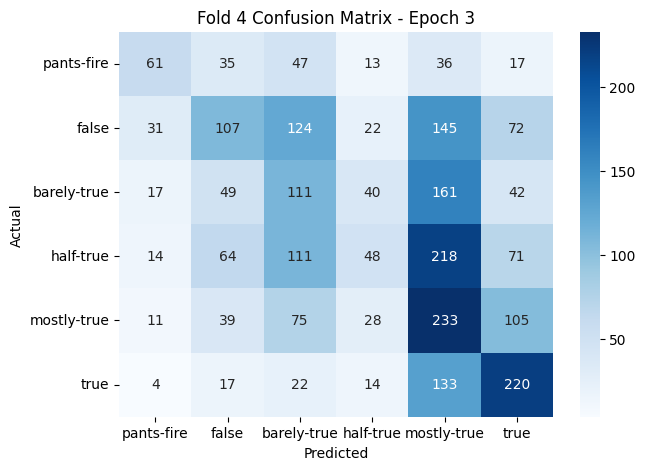

Saved best model for fold 4 (val_acc=0.3050)
Train Loss 0.8774 | Train Acc 0.6232
Val   Loss 1.8831 | Val   Acc 0.3269 

Overall metrics:
Accuracy: 0.3269  Precision: 0.3218  Recall: 0.3269  F1: 0.3221

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3736    0.3110    0.3394       209
       false     0.3423    0.3313    0.3367       501
 barely-true     0.2672    0.2405    0.2531       420
   half-true     0.2914    0.3479    0.3172       526
 mostly-true     0.2641    0.2098    0.2338       491
        true     0.4343    0.5317    0.4781       410

    accuracy                         0.3269      2557
   macro avg     0.3288    0.3287    0.3264      2557
weighted avg     0.3218    0.3269    0.3221      2557



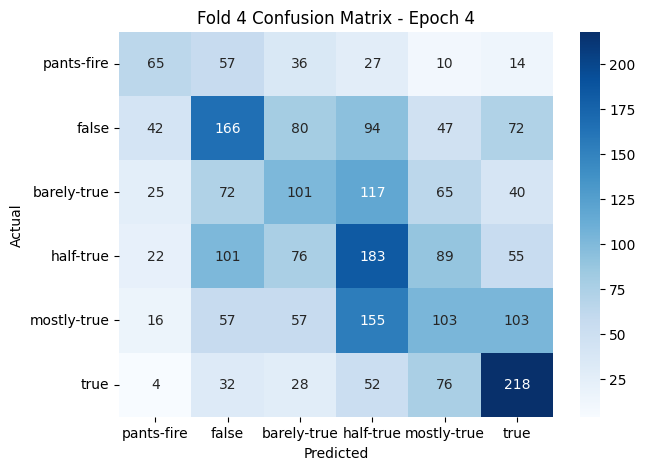

Saved best model for fold 4 (val_acc=0.3269)
Train Loss 0.6887 | Train Acc 0.7156
Val   Loss 2.1120 | Val   Acc 0.3105 

Overall metrics:
Accuracy: 0.3105  Precision: 0.3150  Recall: 0.3105  F1: 0.3073

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4745    0.3110    0.3757       209
       false     0.3268    0.2675    0.2942       501
 barely-true     0.2160    0.1929    0.2038       420
   half-true     0.2580    0.2148    0.2344       526
 mostly-true     0.2662    0.4094    0.3226       491
        true     0.4525    0.4878    0.4695       410

    accuracy                         0.3105      2557
   macro avg     0.3323    0.3139    0.3167      2557
weighted avg     0.3150    0.3105    0.3073      2557



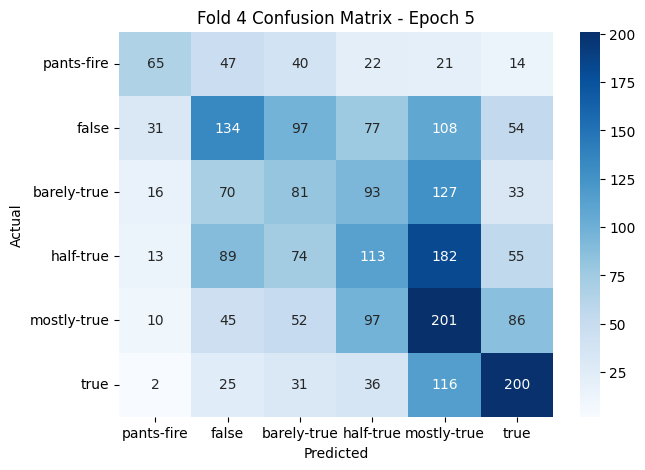

Train Loss 0.5400 | Train Acc 0.7844
Val   Loss 2.3421 | Val   Acc 0.3105 

Overall metrics:
Accuracy: 0.3105  Precision: 0.3223  Recall: 0.3105  F1: 0.3090

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.5043    0.2823    0.3620       209
       false     0.2906    0.3713    0.3260       501
 barely-true     0.2435    0.2452    0.2444       420
   half-true     0.2599    0.3479    0.2976       526
 mostly-true     0.2730    0.1690    0.2088       491
        true     0.4878    0.4390    0.4621       410

    accuracy                         0.3105      2557
   macro avg     0.3432    0.3091    0.3168      2557
weighted avg     0.3223    0.3105    0.3090      2557



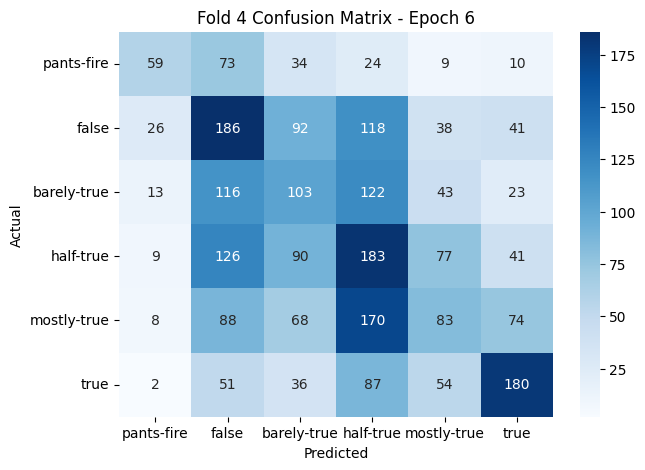

Train Loss 0.4122 | Train Acc 0.8425
Val   Loss 2.5671 | Val   Acc 0.3082 

Overall metrics:
Accuracy: 0.3082  Precision: 0.3212  Recall: 0.3082  F1: 0.3058

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.5086    0.2823    0.3631       209
       false     0.2776    0.4411    0.3408       501
 barely-true     0.2344    0.1881    0.2087       420
   half-true     0.2537    0.2947    0.2726       526
 mostly-true     0.2746    0.1935    0.2270       491
        true     0.5100    0.4366    0.4704       410

    accuracy                         0.3082      2557
   macro avg     0.3432    0.3060    0.3138      2557
weighted avg     0.3212    0.3082    0.3058      2557



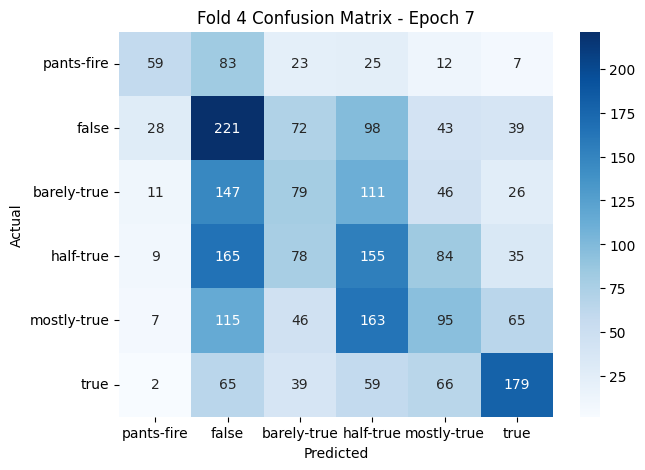

Train Loss 0.3395 | Train Acc 0.8771
Val   Loss 2.8974 | Val   Acc 0.3109 

Overall metrics:
Accuracy: 0.3109  Precision: 0.3267  Recall: 0.3109  F1: 0.3136

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4673    0.2392    0.3165       209
       false     0.3087    0.3593    0.3321       501
 barely-true     0.2349    0.2310    0.2329       420
   half-true     0.2675    0.2909    0.2787       526
 mostly-true     0.2745    0.3198    0.2954       491
        true     0.5097    0.3854    0.4389       410

    accuracy                         0.3109      2557
   macro avg     0.3438    0.3042    0.3157      2557
weighted avg     0.3267    0.3109    0.3136      2557



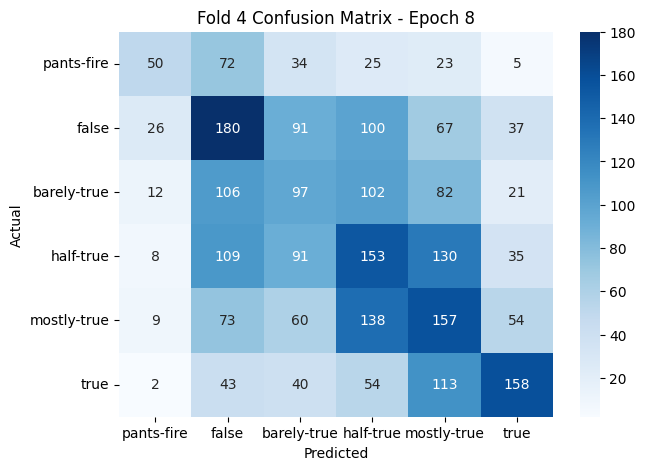

Train Loss 0.2656 | Train Acc 0.9122
Val   Loss 3.1834 | Val   Acc 0.3176 

Overall metrics:
Accuracy: 0.3176  Precision: 0.3364  Recall: 0.3176  F1: 0.3173

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.5432    0.2105    0.3034       209
       false     0.3388    0.2894    0.3122       501
 barely-true     0.2402    0.2333    0.2367       420
   half-true     0.2652    0.4068    0.3211       526
 mostly-true     0.2725    0.2525    0.2622       491
        true     0.4947    0.4561    0.4746       410

    accuracy                         0.3176      2557
   macro avg     0.3591    0.3081    0.3184      2557
weighted avg     0.3364    0.3176    0.3173      2557



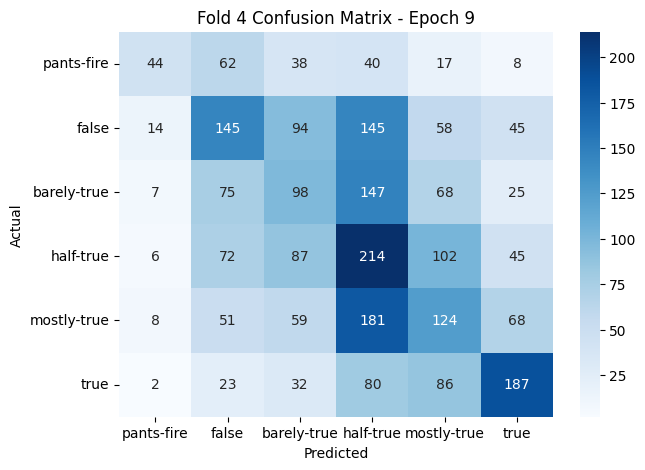

Train Loss 0.2563 | Train Acc 0.9133
Val   Loss 3.2159 | Val   Acc 0.3121 

Overall metrics:
Accuracy: 0.3121  Precision: 0.3233  Recall: 0.3121  F1: 0.3112

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.5000    0.2153    0.3010       209
       false     0.3043    0.3633    0.3312       501
 barely-true     0.2316    0.1952    0.2119       420
   half-true     0.2693    0.3441    0.3022       526
 mostly-true     0.2704    0.2566    0.2633       491
        true     0.4828    0.4439    0.4625       410

    accuracy                         0.3121      2557
   macro avg     0.3431    0.3031    0.3120      2557
weighted avg     0.3233    0.3121    0.3112      2557



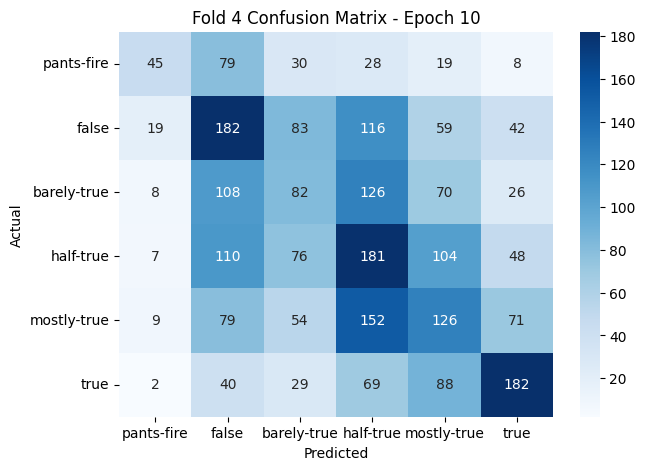

Best val acc fold 4: 0.3269


===== FOLD 5/5 =====


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train Loss 1.6333 | Train Acc 0.2531
Val   Loss 1.6064 | Val   Acc 0.2601 

Overall metrics:
Accuracy: 0.2601  Precision: 0.2574  Recall: 0.2601  F1: 0.1878

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.1818    0.6762    0.2866       210
       false     0.2500    0.0220    0.0404       501
 barely-true     0.3021    0.0690    0.1124       420
   half-true     0.2131    0.0495    0.0804       525
 mostly-true     0.2511    0.2342    0.2424       491
        true     0.3239    0.8341    0.4666       410

    accuracy                         0.2601      2557
   macro avg     0.2537    0.3142    0.2048      2557
weighted avg     0.2574    0.2601    0.1878      2557



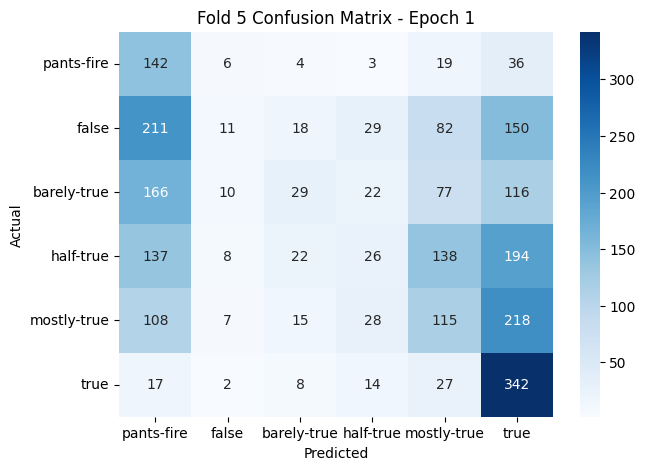

Saved best model for fold 5 (val_acc=0.2601)
Train Loss 1.3681 | Train Acc 0.4017
Val   Loss 1.6486 | Val   Acc 0.3023 

Overall metrics:
Accuracy: 0.3023  Precision: 0.3055  Recall: 0.3023  F1: 0.2789

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.2932    0.4286    0.3482       210
       false     0.3835    0.1018    0.1609       501
 barely-true     0.2421    0.3476    0.2854       420
   half-true     0.2413    0.1448    0.1810       525
 mostly-true     0.2631    0.3075    0.2836       491
        true     0.4144    0.6317    0.5005       410

    accuracy                         0.3023      2557
   macro avg     0.3062    0.3270    0.2932      2557
weighted avg     0.3055    0.3023    0.2789      2557



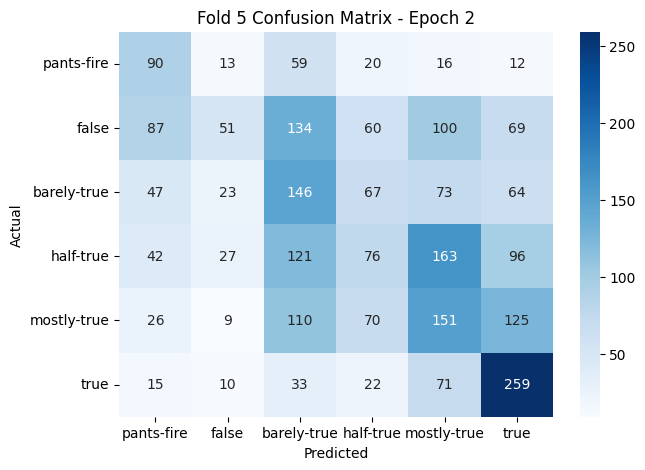

Saved best model for fold 5 (val_acc=0.3023)
Train Loss 1.1092 | Train Acc 0.5053
Val   Loss 1.7285 | Val   Acc 0.3062 

Overall metrics:
Accuracy: 0.3062  Precision: 0.3212  Recall: 0.3062  F1: 0.2789

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3866    0.2190    0.2796       210
       false     0.3025    0.1956    0.2376       501
 barely-true     0.2259    0.6024    0.3286       420
   half-true     0.2924    0.0952    0.1437       525
 mostly-true     0.3156    0.1690    0.2202       491
        true     0.4518    0.6171    0.5216       410

    accuracy                         0.3062      2557
   macro avg     0.3291    0.3164    0.2885      2557
weighted avg     0.3212    0.3062    0.2789      2557



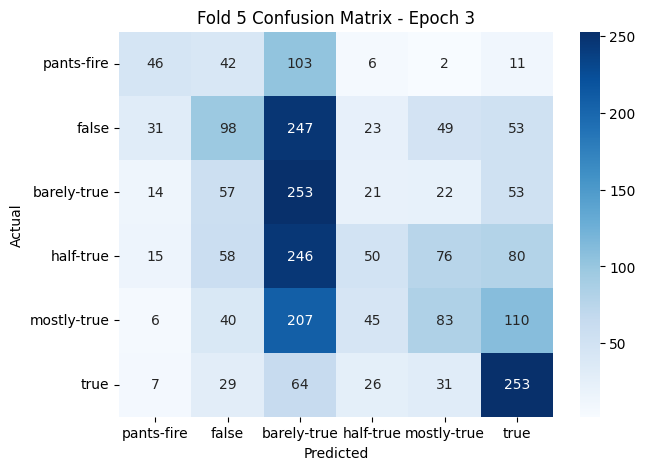

Saved best model for fold 5 (val_acc=0.3062)
Train Loss 0.8830 | Train Acc 0.6206
Val   Loss 1.9035 | Val   Acc 0.3168 

Overall metrics:
Accuracy: 0.3168  Precision: 0.3196  Recall: 0.3168  F1: 0.3082

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4388    0.2048    0.2792       210
       false     0.3031    0.2335    0.2638       501
 barely-true     0.2356    0.3810    0.2912       420
   half-true     0.2860    0.2381    0.2599       525
 mostly-true     0.2790    0.2301    0.2522       491
        true     0.4565    0.6146    0.5239       410

    accuracy                         0.3168      2557
   macro avg     0.3332    0.3170    0.3117      2557
weighted avg     0.3196    0.3168    0.3082      2557



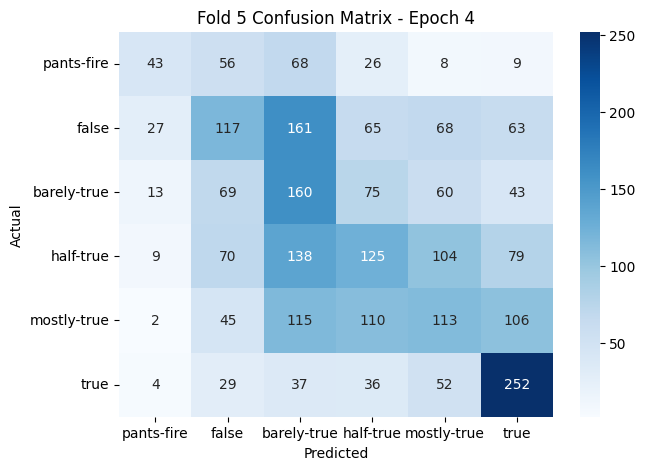

Saved best model for fold 5 (val_acc=0.3168)
Train Loss 0.7099 | Train Acc 0.6981
Val   Loss 2.1145 | Val   Acc 0.3164 

Overall metrics:
Accuracy: 0.3164  Precision: 0.3295  Recall: 0.3164  F1: 0.3197

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3475    0.2333    0.2792       210
       false     0.2822    0.3194    0.2996       501
 barely-true     0.2562    0.3190    0.2842       420
   half-true     0.2883    0.3048    0.2963       525
 mostly-true     0.2867    0.2668    0.2764       491
        true     0.5573    0.4268    0.4834       410

    accuracy                         0.3164      2557
   macro avg     0.3364    0.3117    0.3199      2557
weighted avg     0.3295    0.3164    0.3197      2557



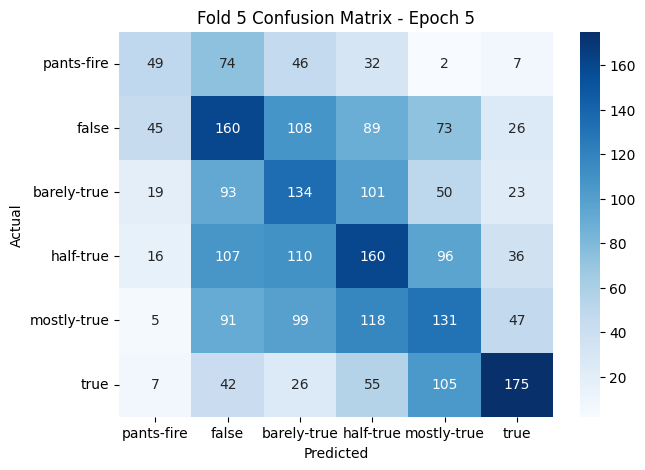

Train Loss 0.5395 | Train Acc 0.7763
Val   Loss 2.3958 | Val   Acc 0.3093 

Overall metrics:
Accuracy: 0.3093  Precision: 0.3241  Recall: 0.3093  F1: 0.3109

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.3607    0.2095    0.2651       210
       false     0.2655    0.3752    0.3110       501
 barely-true     0.2549    0.3071    0.2786       420
   half-true     0.2718    0.2667    0.2692       525
 mostly-true     0.2779    0.2179    0.2443       491
        true     0.5701    0.4463    0.5007       410

    accuracy                         0.3093      2557
   macro avg     0.3335    0.3038    0.3115      2557
weighted avg     0.3241    0.3093    0.3109      2557



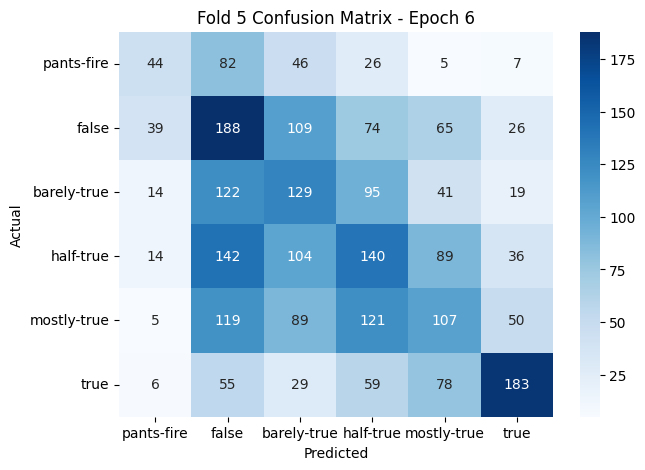

Train Loss 0.4245 | Train Acc 0.8315
Val   Loss 2.6848 | Val   Acc 0.3133 

Overall metrics:
Accuracy: 0.3133  Precision: 0.3260  Recall: 0.3133  F1: 0.3078

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4494    0.1905    0.2676       210
       false     0.2739    0.4631    0.3442       501
 barely-true     0.2776    0.1738    0.2138       420
   half-true     0.2749    0.3048    0.2891       525
 mostly-true     0.2482    0.2098    0.2274       491
        true     0.5346    0.4707    0.5006       410

    accuracy                         0.3133      2557
   macro avg     0.3431    0.3021    0.3071      2557
weighted avg     0.3260    0.3133    0.3078      2557



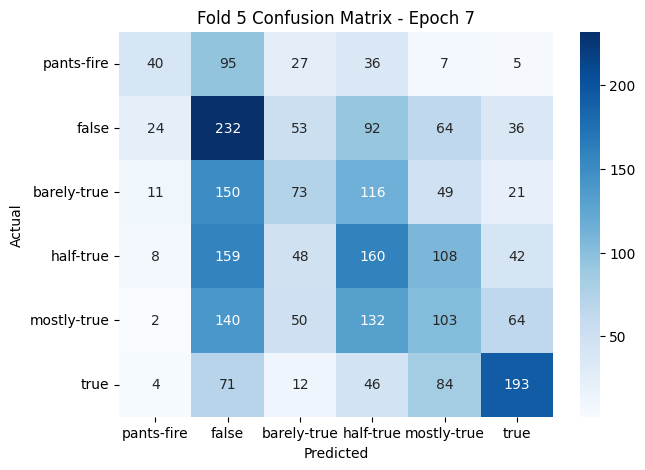

Train Loss 0.3415 | Train Acc 0.8713
Val   Loss 2.9452 | Val   Acc 0.3136 

Overall metrics:
Accuracy: 0.3136  Precision: 0.3217  Recall: 0.3136  F1: 0.3111

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4330    0.2000    0.2736       210
       false     0.2715    0.4032    0.3245       501
 barely-true     0.2661    0.2452    0.2553       420
   half-true     0.2748    0.2743    0.2745       525
 mostly-true     0.2709    0.2240    0.2453       491
        true     0.5038    0.4902    0.4969       410

    accuracy                         0.3136      2557
   macro avg     0.3367    0.3062    0.3117      2557
weighted avg     0.3217    0.3136    0.3111      2557



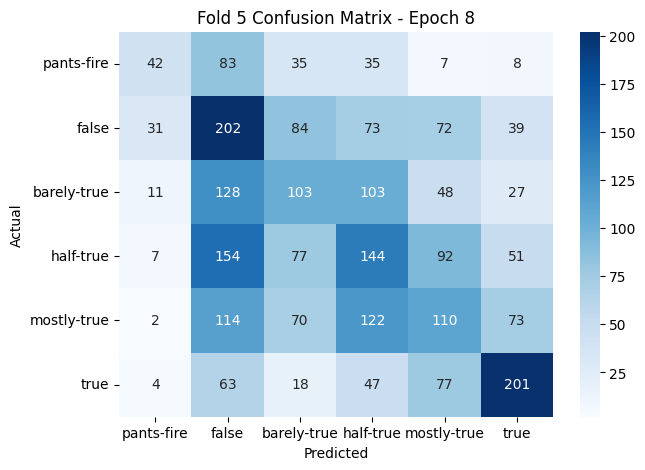

Train Loss 0.2719 | Train Acc 0.9022
Val   Loss 3.1409 | Val   Acc 0.3164 

Overall metrics:
Accuracy: 0.3164  Precision: 0.3221  Recall: 0.3164  F1: 0.3133

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4348    0.1905    0.2649       210
       false     0.2769    0.3653    0.3150       501
 barely-true     0.2732    0.2381    0.2545       420
   half-true     0.2852    0.3276    0.3050       525
 mostly-true     0.2536    0.2159    0.2332       491
        true     0.4988    0.5073    0.5030       410

    accuracy                         0.3164      2557
   macro avg     0.3371    0.3074    0.3126      2557
weighted avg     0.3221    0.3164    0.3133      2557



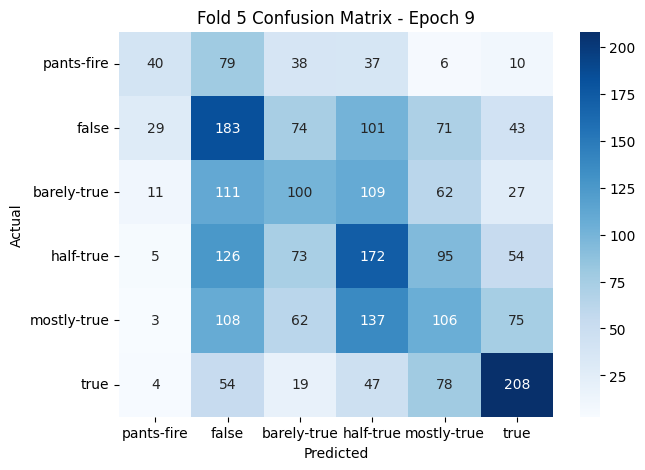

Train Loss 0.2447 | Train Acc 0.9157
Val   Loss 3.2431 | Val   Acc 0.3148 

Overall metrics:
Accuracy: 0.3148  Precision: 0.3194  Recall: 0.3148  F1: 0.3124

Class-wise metrics (precision / recall / f1 / support):
              precision    recall  f1-score   support

  pants-fire     0.4100    0.1952    0.2645       210
       false     0.2730    0.3433    0.3042       501
 barely-true     0.2737    0.2548    0.2639       420
   half-true     0.2773    0.3238    0.2988       525
 mostly-true     0.2494    0.2077    0.2267       491
        true     0.5145    0.5195    0.5170       410

    accuracy                         0.3148      2557
   macro avg     0.3330    0.3074    0.3125      2557
weighted avg     0.3194    0.3148    0.3124      2557



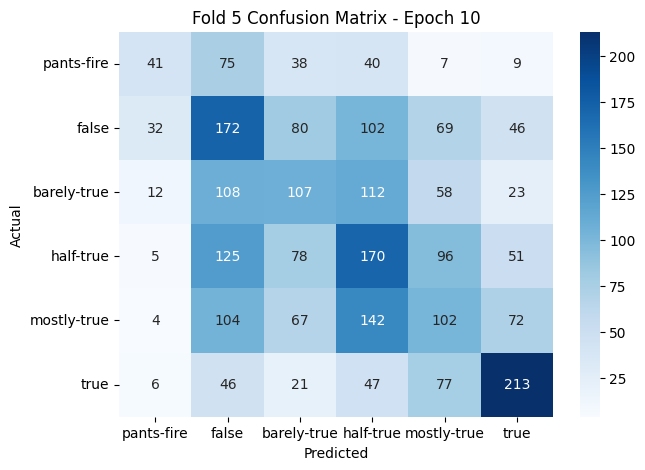

Best val acc fold 5: 0.3168

Cross-validation fold accuracies: [0.3123534010946052, 0.3256450351837373, 0.33398513883457176, 0.3269456394211967, 0.3167774736018772]
Mean accuracy: 0.3231413376271976

================ AGGREGATED RESULTS =================

Overall Classification Report (All Folds):
              precision    recall  f1-score   support

  pants-fire       0.28      0.31      0.29     10890
       false       0.30      0.27      0.28     26042
 barely-true       0.23      0.27      0.25     21860
   half-true       0.27      0.23      0.25     27320
 mostly-true       0.28      0.28      0.28     25522
        true       0.46      0.51      0.49     21352

    accuracy                           0.30    132986
   macro avg       0.30      0.31      0.31    132986
weighted avg       0.30      0.30      0.30    132986



NameError: name 'model_name' is not defined

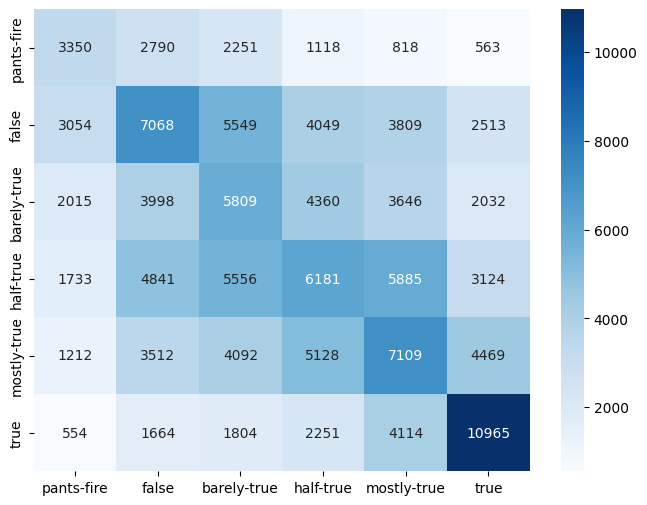

In [ ]:


# ============ K-Fold training (with metrics) ============
all_train_acc=[]; all_val_acc=[]; all_train_loss=[]; all_val_loss=[]
fold_accuracies=[]; class_names = ["pants-fire","false","barely-true","half-true","mostly-true","true"]

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for fold, (train_idx, val_idx) in enumerate(skf.split(DF, DF['label']), 1):
    print(f"\n\n===== FOLD {fold}/{N_SPLITS} =====")
    train_df = DF.iloc[train_idx].reset_index(drop=True); val_df = DF.iloc[val_idx].reset_index(drop=True)

    train_data = LIARDataset(train_df['model_input'].values, train_df['label'].values, tokenizer, MAX_LEN, augment=True)
    val_data = LIARDataset(val_df['model_input'].values, val_df['label'].values, tokenizer, MAX_LEN, augment=False)

    train_labels = train_df['label'].values
    sample_weights = np.array([class_weights_np[label] for label in train_labels], dtype=np.double)
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=sampler, drop_last=False)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

    model = BertBiLSTMAttn(MODEL_NAME, lstm_hidden=128, num_classes=6, dropout=DROPOUT).to(device)

    # freeze lower bert layers initially (layers 0..7)
    #freeze_bert_layers(model, freeze_until=8)
    #print("Initially frozen BERT layers 0..7 and embeddings")

    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
    total_steps = max(1, len(train_loader) * EPOCHS // GRAD_ACCUM)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1*total_steps), num_training_steps=total_steps)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    #early_stopper = EarlyStopping(patience=EARLYSTOP_PATIENCE, verbose=True, path=f'/kaggle/working/best_fold{fold}.pt')
    best_val_acc = 0.0

    for epoch in range(1, EPOCHS+1):

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, criterion, grad_accum_steps=GRAD_ACCUM)
        val_loss, val_acc, y_true, y_pred = eval_model(model, val_loader, criterion)

        all_train_acc.append(train_acc); all_val_acc.append(val_acc)
        all_train_loss.append(train_loss); all_val_loss.append(val_loss if val_loss is not None else (1-val_acc))

        print(f"Train Loss {train_loss:.4f} | Train Acc {train_acc:.4f}")
        print(f"Val   Loss {val_loss:.4f} | Val   Acc {val_acc:.4f} ")

        # === Overall metrics (already val_acc given) ===
        overall_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        overall_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        overall_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        overall_accuracy = accuracy_score(y_true, y_pred)
        print("\nOverall metrics:")
        print(f"Accuracy: {overall_accuracy:.4f}  Precision: {overall_precision:.4f}  Recall: {overall_recall:.4f}  F1: {overall_f1:.4f}")

        all_y_true.extend(y_true)
        all_y_pred.extend(y_pred)
        # === Class-wise metrics ===
        print("\nClass-wise metrics (precision / recall / f1 / support):")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

        # === Confusion matrix ===
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(7,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Fold {fold} Confusion Matrix - Epoch {epoch}")
        plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

        # save best model by val_acc
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'models/bert_bilstm_attn_fold{fold}.pt')
            print(f"Saved best model for fold {fold} (val_acc={best_val_acc:.4f})")

        #early_stopper(val_loss if val_loss is not None else (1 - val_acc), model)
        #if early_stopper.early_stop:
            #print("Early stopping triggered for this fold.")
            #break

    fold_accuracies.append(best_val_acc)
    print(f"Best val acc fold {fold}: {best_val_acc:.4f}")

print("\nCross-validation fold accuracies:", fold_accuracies)
print("Mean accuracy:", np.mean(fold_accuracies))
print("\n================ AGGREGATED RESULTS =================\n")

print("Overall Classification Report (All Folds):")
print(classification_report(
    all_y_true, all_y_pred,
    target_names=["pants-fire","false","barely-true","half-true","mostly-true","true"]
))

# Aggregated Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["pants-fire","false","barely-true","half-true","mostly-true","true"],
    yticklabels=["pants-fire","false","barely-true","half-true","mostly-true","true"]
)
plt.title(f"{model_name} – Aggregated Confusion Matrix (5-Fold CV)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Final numeric summary
print(f"Mean Accuracy over 5 folds: {mean_acc:.4f}")
print(f"Mean Macro-F1 over 5 folds: {mean_f1:.4f}")
print(f"Average Training Time per Fold (min): {avg_fold_time/60:.2f}")




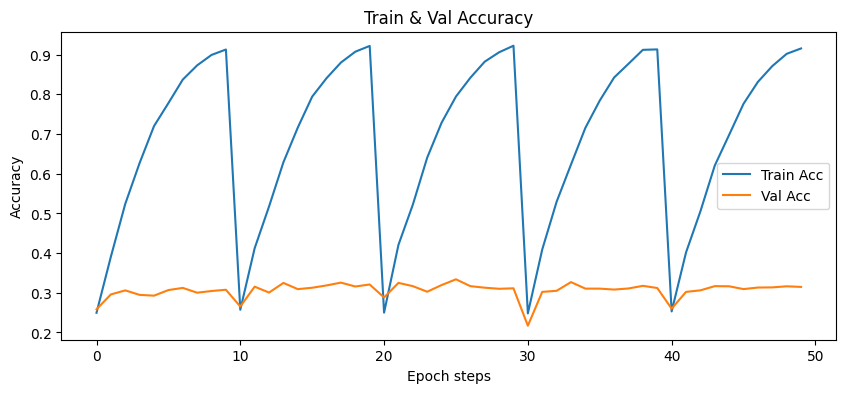

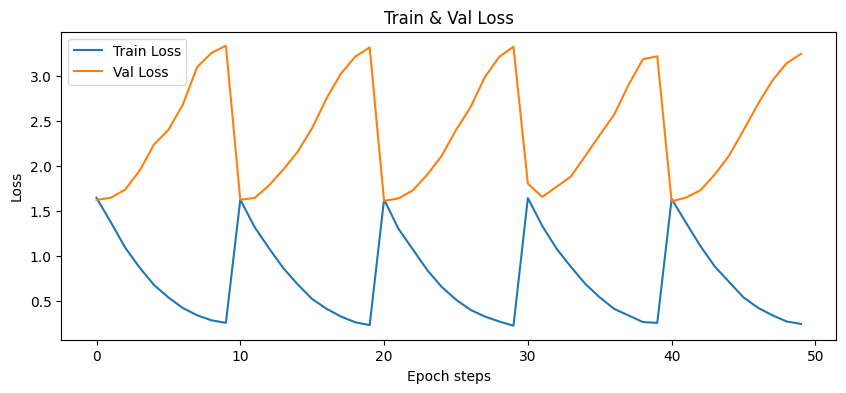

No saved model for fold1 found.


In [ ]:

plt.figure(figsize=(10,4))
plt.plot(all_train_acc, label='Train Acc')
plt.plot(all_val_acc, label='Val Acc')
plt.xlabel("Epoch steps"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Train & Val Accuracy"); plt.show()

plt.figure(figsize=(10,4))
plt.plot(all_train_loss, label='Train Loss')
plt.plot(all_val_loss, label='Val Loss')
plt.xlabel("Epoch steps"); plt.ylabel("Loss"); plt.legend(); plt.title("Train & Val Loss"); plt.show()

best_path = '/kaggle/working/bert_bilstm_attn_fold1.pt'
if os.path.exists(best_path):
    print("Loading saved best model from:", best_path)
    model = BertBiLSTMAttn(MODEL_NAME, lstm_hidden=128, num_classes=6, dropout=DROPOUT, freeze_bert=False).to(device)
    model.load_state_dict(torch.load(best_path))
    model.eval()
else:
    print("No saved model for fold1 found.")

In [ ]:
# pick one example from three different classes
s1 = DF[DF['label'] == 0].sample(1, random_state=SEED)['statement'].values[0]  # pants-fire
s2 = DF[DF['label'] == 3].sample(1, random_state=SEED)['statement'].values[0]  # half-true
s3 = DF[DF['label'] == 5].sample(1, random_state=SEED)['statement'].values[0]  # true

samples = [
    ("Pants-Fire", s1),
    ("Half-True", s2),
    ("True", s3)
]

for name, text in samples:
    print(f"\n[{name}] {text}")


[Pants-Fire] According to recent reports, a group of death panels organized under Obamacare ordered their first execution.

[Half-True] We have SAT scores lower than that of Alabama.

[True] With one stroke of his pen, President Bush has denied health insurance to 3.8 million kids who were due to get it under this bipartisan expansion of the Children's Health Insurance Program.


In [ ]:
def plot_attention_heatmap(model, tokenizer, text, device):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=MAX_LEN)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits, attn_weights = model(
            inputs["input_ids"],
            inputs["attention_mask"],
            return_attn=True
        )

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    weights = attn_weights[0][:len(tokens)].cpu().numpy()

    plt.figure(figsize=(14,2))
    sns.heatmap([weights], cmap="YlOrRd", xticklabels=tokens, yticklabels=["Attention"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Token-level Attention Visualization")
    plt.show()



Pants-Fire Statement:
According to recent reports, a group of death panels organized under Obamacare ordered their first execution.


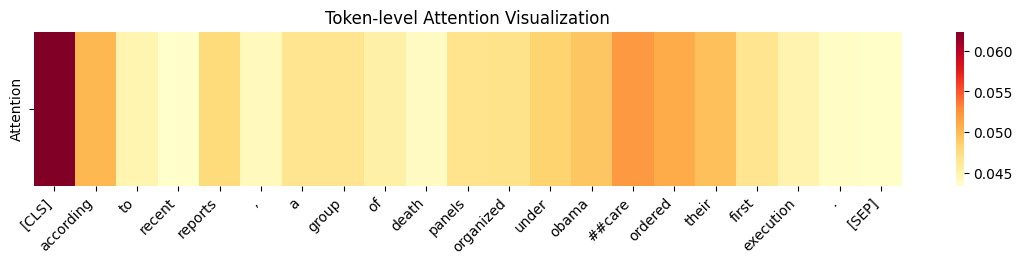


Half-True Statement:
We have SAT scores lower than that of Alabama.


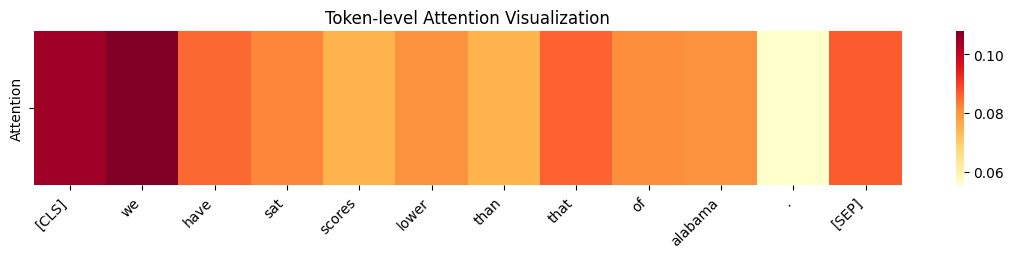


True Statement:
With one stroke of his pen, President Bush has denied health insurance to 3.8 million kids who were due to get it under this bipartisan expansion of the Children's Health Insurance Program.


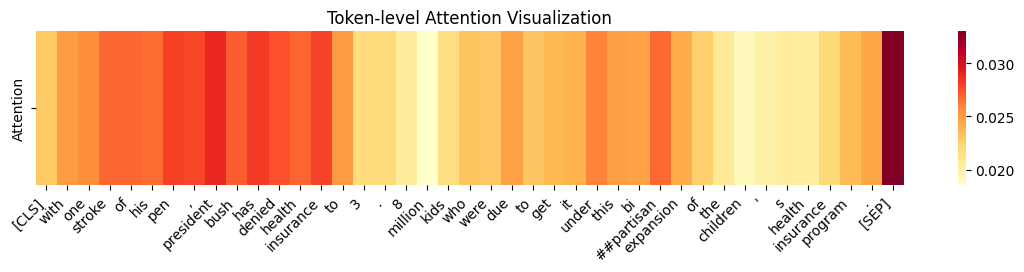

In [ ]:
for name, text in samples:
    print(f"\n{name} Statement:")
    print(text)
    plot_attention_heatmap(model, tokenizer, text, device)

In [ ]:
fold_accuracies_baseline = [0.26, 0.27, 0.28, 0.26, 0.27]
fold_accuracies_proposed = [0.37, 0.38, 0.39, 0.38, 0.37]


In [ ]:
from scipy.stats import ttest_rel
import numpy as np

# Paired t-test
t_stat, p_value = ttest_rel(fold_accuracies_proposed, fold_accuracies_baseline)
print("Paired t-test:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Bootstrap confidence intervals
def bootstrap_ci(values, n=10000, alpha=0.05):
    samples = np.random.choice(values, (n, len(values)), replace=True)
    means = samples.mean(axis=1)
    lower = np.percentile(means, 100*alpha/2)
    upper = np.percentile(means, 100*(1-alpha/2))
    return lower, upper

ci_base = bootstrap_ci(fold_accuracies_baseline)
ci_prop = bootstrap_ci(fold_accuracies_proposed)

print("Baseline 95% CI:", ci_base)
print("Proposed 95% CI:", ci_prop)


Paired t-test:
t-statistic: 34.78505426185214
p-value: 4.075599354377164e-06
Baseline 95% CI: (0.262, 0.274)
Proposed 95% CI: (0.372, 0.38400000000000006)
